In [1]:
!pwd

/Users/macbook/divtel


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import sys
from ipywidgets import interactive, FloatSlider, interact, fixed
from divtel import *


import copy
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroplan.plots import plot_sky
from astroplan import FixedTarget
#from . import utils
#from .const import COLORS
#from . import pointing

from matplotlib.transforms import Affine2D
from astropy.visualization.wcsaxes import SphericalCircle

import healpy as hp
import tqdm

#!jupyter labextension install @jupyter-widgets/jupyterlab-manager

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## LOAD CTA CONFIG

In [3]:
cta = CTA_Info('south')

Observer         :  CTA South
Location         :  Paranal , (1946.635798, -5467.63394562, -2642.49852123) km
Observation time :  2024-12-15T10:25:37.957


In [4]:
# Note that if the radius is in meters, 
# you can set LoadConfig(file, radius="meters")
# defalut is in degrees

array = LoadConfig("/Users/macbook/divtel/ParanalArrayPositions_divProd6.txt", frame=cta)
full_array= LoadConfig("/Users/macbook/divtel/Paranal_only_MST.txt", frame=cta)

## Check configuration table

In [5]:
array.table.units = "deg"
array.table
full_array.table

<Table length=14>
  id     x       y       z       az   ...   p_x     p_y     p_z    d_tel 
         m       m       m      rad   ...                            m   
int64 float64 float64 float64 float64 ... float64 float64 float64 float64
----- ------- ------- ------- ------- ... ------- ------- ------- -------
    1     0.0     0.0    24.0   0.000 ...   1.000  -0.000   0.000   22.65
    2     0.0   151.0    25.0   0.000 ...   1.000  -0.000   0.000  152.67
    3     0.0  -151.0    31.0   0.000 ...   1.000  -0.000   0.000  152.68
    4   150.0    75.0    21.0   0.000 ...   1.000  -0.000   0.000  188.09
    5   150.0   -75.0    26.0   0.000 ...   1.000  -0.000   0.000  187.98
    6   150.0   240.0    24.0   0.000 ...   1.000  -0.000   0.000  295.50
    7   150.0  -240.0    30.0   0.000 ...   1.000  -0.000   0.000  295.49
    8   313.0     0.0    19.0   0.000 ...   1.000  -0.000   0.000  335.47
    9  -150.0   -75.0    28.0   0.000 ...   1.000  -0.000   0.000  148.05
   10  -150.0    75.0    28.0   0.000 ...   1.000  -0.000   0.000  148.05
   11  -150.0  -240.0    38.5   0.000 ...   1.000  -0.000   0.000  272.05
   12  -150.0   240.0    27.0   0.000 ...   1.000  -0.000   0.000  271.83
   13  -313.0  -162.0    35.0   0.000 ...   1.000  -0.000   0.000  332.82
   14  -313.0   162.0    30.5   0.000 ...   1.000  -0.000   0.000  332.75

In [6]:
table=array.table

## Check the telescope spatial distribution
This is useful to pick the groups

In [7]:
array.table

<Table length=64>
  id     x       y       z       az   ...   p_x     p_y     p_z    d_tel 
         m       m       m      deg   ...                            m   
int64 float64 float64 float64 float64 ... float64 float64 float64 float64
----- ------- ------- ------- ------- ... ------- ------- ------- -------
    1   -20.0   -65.0    34.0   0.000 ...   1.000  -0.000   0.000   66.52
    2    80.0     0.0    29.0   0.000 ...   1.000  -0.000   0.000   86.67
    3   -20.0    65.0    31.0   0.000 ...   1.000  -0.000   0.000   66.37
    4  -120.0     0.0    33.0   0.000 ...   1.000  -0.000   0.000  113.39
    5     0.0     0.0    24.0   0.000 ...   1.000  -0.000   0.000    8.55
    6     0.0   151.0    25.0   0.000 ...   1.000  -0.000   0.000  151.21
    7     0.0  -151.0    31.0   0.000 ...   1.000  -0.000   0.000  151.16
    8   150.0    75.0    21.0   0.000 ...   1.000  -0.000   0.000  173.90
    9   150.0   -75.0    26.0   0.000 ...   1.000  -0.000   0.000  173.73
  ...     ...     ...     ...     ... ...     ...     ...     ...     ...
   56   748.0   367.0    6.25   0.000 ...   1.000  -0.000   0.000  839.50
   57   816.0  -648.0   41.25   0.000 ...   1.000  -0.000   0.000 1047.30
   58   816.0   648.0   18.75   0.000 ...   1.000  -0.000   0.000 1047.28
   59     0.0  -950.0   75.25   0.000 ...   1.000  -0.000   0.000  951.13
   60     0.0   950.0   28.25   0.000 ...   1.000  -0.000   0.000  950.02
   61  -955.0  -199.0   39.25   0.000 ...   1.000  -0.000   0.000  969.03
   62  -955.0   199.0   22.75   0.000 ...   1.000  -0.000   0.000  969.01
   63   955.0  -199.0    7.75   0.000 ...   1.000  -0.000   0.000  982.28
   64   955.0   199.0    5.25   0.000 ...   1.000  -0.000   0.000  982.34

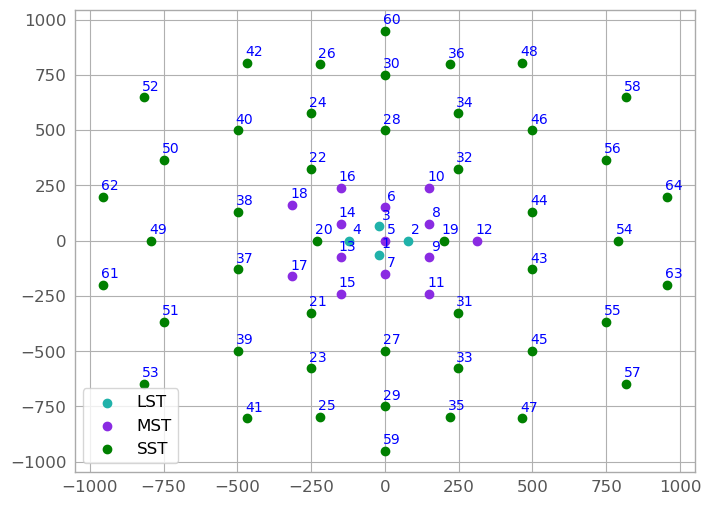

In [8]:
# Loop through all the telescopes
#for fov in array.table["fov"]:
#    print(fov)
colors = [
    'lightseagreen' if np.isclose(fov, 14.5356) else
    'blueviolet' if np.isclose(fov, 46.707) else 
    'green' if np.isclose(fov, 62.462) else
    'red'  # Default color if none of the conditions match
    for fov in array.table["fov"]
]
fov_labels = {
    'lightseagreen': 'LST',
    'blueviolet': 'MST',
    'green': 'SST'
}
for i in range(len(array.table)):
    plt.scatter(array.table['x'][i], array.table['y'][i], c=colors[i], label=fov_labels[colors[i]])

    # Annotate each point with the telescope ID
    #matplotlib.pyplot.annotate(text, xy, xytext=None, xycoords='data', textcoords=None, arrowprops=None, annotation_clip=None, **kwargs)
#Annotate the point xy with text text.
#In the simplest form, the text is placed at xy.
    plt.annotate(str(array.table["id"][i]),
                 (array.table['x'][i], array.table['y'][i]),  # Point position
                 textcoords="offset points",  # Text position relative to the point
                 xytext=(5, 5),  # Offset in pixels (to avoid overlapping the point)
                 ha='center', fontsize=10, color='blue')
handles, labels = plt.gca().get_legend_handles_labels()
#handles, labels like this is doing
    #plt.gca() gets the current Axes object, which is where your plot is
    #.get_legend_handles_labels()
        #handles: Returns a list of the graphical elements (e.g., lines, scatter plot points) that would appear in the legend.
        # labels: Returns the text labels associated with each graphical element in handles

by_label = dict(zip(labels, handles))  # Remove duplicate labels, the dictionary by the structure takes out the double 
plt.legend(by_label.values(), by_label.keys())
#by_label.values This is pulling out the unique graphical elements
# by_label.keys  This is retrieving the unique text 
plt.savefig("./different_telescopes.png", dpi=300, bbox_inches="tight")
plt.show() 

## Check the hyper field of view (hFoV)

This is the whole telescope array hFoV maybe? (ask)

In [9]:
array.hFoV(m_cut=3) 

64it [00:08,  7.30it/s]


(62.238869377690584, 57.415086388537716)

In [10]:
#array.hFoV(m_cut=3)

## Grouping telescopes

In [11]:
sub_groups={'1':[18,16,6,14], 
            '2': [5,7,9,11],
            '3': [13,15,17], 
            '4': [8,10,12]}
sub_groups_2 = {'1':[18,17,16,14], 
                '2': [13,15,5,7],
                '3': [6,8,10],
                '4': [9,11,12]
              }
sub_groups_3={'1':[18,14,13,17],
             '2':[7,11,15],
             '3':[5,8,9,12],
             '4':[16,6,10]}


In [19]:
def compute_center_of_gravity(group):
    x, y, z = group['x'], group['y'], group['z']
    cog_x = round(np.mean(x),2)
    cog_y = round(np.mean(y),2)
    cog_z = round(np.mean(z),2)
    return cog_x, cog_y, cog_z

# Function to create new telescope list with center of gravity
def create_new_group_list(tel_group):
    new_telescopes = []
    for group in tel_group.groups:
        print(tel_group.groups)
        print (group['focal'][0],round(group['radius'][0],2))
        #id_ = group["id"][0]
        cog = compute_center_of_gravity(group)
        focal, fov = group['focal'][0], round(group['radius'][0],2)  # Assuming same within a group
        new_telescopes.append([*cog, focal, fov])
    return new_telescopes


In [12]:
tel_group_2, labels_2, number_of_telescopes_subarray_2 =array.group_by(sub_groups_2)
#tel_group_3, labels_3 = group_by(array, group=only_MST)

In [40]:
tel_group, labels, number_of_telescopes_subarray_1 =array.group_by(sub_groups)

In [41]:
tel_group_3, labels_3, number_of_telescopes_subarray_3 =array.group_by(sub_groups_3)

In [42]:
#tel_group.groups.to_table()
print(number_of_telescopes_subarray_1)
print(labels)
print(type(tel_group.groups))
groups = tel_group.groups
for group in groups:
    print(group) 
    print (group['focal'][0],round(group['radius'][0],2))# Each group is a mini table

[4, 4, 3, 3]
['1', '2', '3', '4']
<class 'astropy.table.groups.TableGroups'>
 id   x      y      z     az   alt  ... radius  fov    p_x   p_y    p_z   d_tel 
      m      m      m    deg   deg  ...  deg    deg2                        m   
--- ------ ------ ----- ----- ----- ... ------ ------ ----- ------ ----- -------
  1  -20.0  -65.0  34.0 0.000 0.000 ...  2.150 14.536 1.000 -0.000 0.000   66.52
  2   80.0    0.0  29.0 0.000 0.000 ...  2.150 14.536 1.000 -0.000 0.000   86.67
  3  -20.0   65.0  31.0 0.000 0.000 ...  2.150 14.536 1.000 -0.000 0.000   66.37
  4 -120.0    0.0  33.0 0.000 0.000 ...  2.150 14.536 1.000 -0.000 0.000  113.39
 19  199.0    0.0 16.25 0.000 0.000 ...  4.450 62.462 1.000 -0.000 0.000  206.09
 20 -230.0    0.0 22.75 0.000 0.000 ...  4.450 62.462 1.000 -0.000 0.000  223.43
 21 -249.0 -325.0 40.75 0.000 0.000 ...  4.450 62.462 1.000 -0.000 0.000  405.56
 22 -249.0  325.0 17.25 0.000 0.000 ...  4.450 62.462 1.000 -0.000 0.000  405.58
 23 -249.0 -577.0 54.25 0.000 0.

In [43]:
# Step 2: Create new telescope list with center of gravity
new_telescopes = create_new_group_list(tel_group)
new_telescopes_2 = create_new_group_list(tel_group_2)
new_telescopes_3 = create_new_group_list(tel_group_3)
#Why are you creating an extra telescope?


<TableGroups indices=[ 0 50 54 58 61 64]>
28.0 2.15
<TableGroups indices=[ 0 50 54 58 61 64]>
16.0 3.85
<TableGroups indices=[ 0 50 54 58 61 64]>
16.0 3.85
<TableGroups indices=[ 0 50 54 58 61 64]>
16.0 3.85
<TableGroups indices=[ 0 50 54 58 61 64]>
16.0 3.85
<TableGroups indices=[ 0 50 54 58 61 64]>
28.0 2.15
<TableGroups indices=[ 0 50 54 58 61 64]>
16.0 3.85
<TableGroups indices=[ 0 50 54 58 61 64]>
16.0 3.85
<TableGroups indices=[ 0 50 54 58 61 64]>
16.0 3.85
<TableGroups indices=[ 0 50 54 58 61 64]>
16.0 3.85
<TableGroups indices=[ 0 50 54 57 61 64]>
28.0 2.15
<TableGroups indices=[ 0 50 54 57 61 64]>
16.0 3.85
<TableGroups indices=[ 0 50 54 57 61 64]>
16.0 3.85
<TableGroups indices=[ 0 50 54 57 61 64]>
16.0 3.85
<TableGroups indices=[ 0 50 54 57 61 64]>
16.0 3.85


In [44]:
#del new_telescopes[0]# Step 3: Output the result
#for telescope in new_telescopes:
#    print(telescope)
del new_telescopes[0]#No clue why it keeps on putting me an extra telescope...soooo... I deleted it... I will find out why
for telescope in new_telescopes:
    print(telescope)

[-153.25, 157.0, 27.62, 16.0, 3.85]
[75.0, -116.5, 27.75, 16.0, 3.85]
[-204.33, -159.0, 33.83, 16.0, 3.85]
[204.33, 105.0, 21.33, 16.0, 3.85]


In [45]:
del new_telescopes_2[0]
for telescope in new_telescopes_2:
    print(telescope)


[-231.5, 78.75, 30.12, 16.0, 3.85]
[-75.0, -116.5, 30.38, 16.0, 3.85]
[100.0, 155.33, 23.33, 16.0, 3.85]
[204.33, -105.0, 25.0, 16.0, 3.85]


In [46]:
del new_telescopes_3[0]
for telescope in new_telescopes_3:
    print(telescope)


[-231.5, 0.0, 30.38, 16.0, 3.85]
[0.0, -210.33, 33.17, 16.0, 3.85]
[153.25, 0.0, 22.5, 16.0, 3.85]
[0.0, 210.33, 25.33, 16.0, 3.85]


In [47]:
# Define the file path where you want to save the output
output_file_path = './subarray_1_2_SOUTH.txt'

# Open the file in write mode
with open(output_file_path, 'w') as file:
    
    # Write a header
    #file.write("Group ID, X_Center, Y_Center, Z_Center, Focal Length, FOV\n")
    
    # Loop through all new telescopes (grouped telescopes)
    for i, telescope in enumerate(new_telescopes):
        # Assuming telescope is a list like [x_center, y_center, z_center, focal_length, fov]
        values = ' '.join(map(str, telescope))  # Convert all elements to string
        # Write the data to the file
        #print(values)
        file.write(f"{values}\n")

print(f"New telescope data has been written to {output_file_path}")


New telescope data has been written to ./subarray_1_2_SOUTH.txt


In [48]:
range(len(array.telescopes))

range(0, 64)

In [49]:
# Define the file path where you want to save the output
output_file_path_2 = 'subarray_2_SOUTH.txt'

# Open the file in write mode
with open(output_file_path_2, 'w') as file:
    
    # Write a header
    #file.write("Group ID, X_Center, Y_Center, Z_Center, Focal Length, FOV\n")
    
    # Loop through all new telescopes (grouped telescopes)
    for i, telescope in enumerate(new_telescopes_2):
        # Assuming telescope is a list like [x_center, y_center, z_center, focal_length, fov]
        values = ' '.join(map(str, telescope))  # Convert all elements to string
        # Write the data to the file
        #print(values)
        file.write(f"{values}\n")

print(f"New telescope data has been written to {output_file_path_2}")


New telescope data has been written to subarray_2_SOUTH.txt


In [50]:
# Define the file path where you want to save the output
output_file_path_3 = 'subarray_3_SOUTH.txt'

# Open the file in write mode
with open(output_file_path_3, 'w') as file:
    
    # Write a header
    #file.write("Group ID, X_Center, Y_Center, Z_Center, Focal Length, FOV\n")
    
    # Loop through all new telescopes (grouped telescopes)
    for i, telescope in enumerate(new_telescopes_3):
        # Assuming telescope is a list like [x_center, y_center, z_center, focal_length, fov]
        values = ' '.join(map(str, telescope))  # Convert all elements to string
        # Write the data to the file
        #print(values)
        file.write(f"{values}\n")

print(f"New telescope data has been written to {output_file_path_3}")


New telescope data has been written to subarray_3_SOUTH.txt


# HERE THERE IS AS WELL THE HFOV AND A MORE DETAILED AND FULL STUDY

## PLOTTING THEM TOGETHER AND DIFFERENT DIVERGENCE

In [51]:
#If you do not do this like this but just put array_alt_1=array and array_alt_2=array you will end up with a problem
#You will end up having them over write each pther because they come from the same point
array_alt_1= LoadConfig("./subarray_1_2_SOUTH.txt", frame=cta, pointing2src=True)
array_alt_1_div_2= LoadConfig("./subarray_1_2_SOUTH.txt", frame=cta, pointing2src=True)
array_alt_1_div_3= LoadConfig("./subarray_1_2_SOUTH.txt", frame=cta, pointing2src=True)
array_alt_2= LoadConfig("./subarray_1_2_SOUTH.txt", frame=cta, pointing2src=True)
array_alt_2_div_2= LoadConfig("./subarray_1_2_SOUTH.txt", frame=cta, pointing2src=True)
array_alt_2_div_3= LoadConfig("./subarray_1_2_SOUTH.txt", frame=cta, pointing2src=True)

array_alt_3= LoadConfig("./subarray_1_2_SOUTH.txt", frame=cta, pointing2src=True)
array_alt_3_div_2= LoadConfig("./subarray_1_2_SOUTH.txt", frame=cta, pointing2src=True)
array_alt_3_div_3= LoadConfig("./subarray_1_2_SOUTH.txt", frame=cta, pointing2src=True)

array_2_alt_1= LoadConfig("./subarray_2_SOUTH.txt", frame=cta, pointing2src=True)
array_2_alt_1_div_2= LoadConfig("./subarray_2_SOUTH.txt", frame=cta, pointing2src=True)
array_2_alt_1_div_3= LoadConfig("./subarray_2_SOUTH.txt", frame=cta, pointing2src=True)

array_2_alt_2= LoadConfig("./subarray_2_SOUTH.txt", frame=cta, pointing2src=True)
array_2_alt_2_div_2= LoadConfig("./subarray_2_SOUTH.txt", frame=cta, pointing2src=True)
array_2_alt_2_div_3= LoadConfig("./subarray_2_SOUTH.txt", frame=cta, pointing2src=True)
array_2_alt_3= LoadConfig("./subarray_2_SOUTH.txt", frame=cta, pointing2src=True)
array_2_alt_3_div_2= LoadConfig("./subarray_2_SOUTH.txt", frame=cta, pointing2src=True)
array_2_alt_3_div_3= LoadConfig("./subarray_2_SOUTH.txt", frame=cta, pointing2src=True)

array_3_alt_1= LoadConfig("./subarray_3_SOUTH.txt", frame=cta, pointing2src=True)
array_3_alt_1_div_2= LoadConfig("./subarray_3_SOUTH.txt", frame=cta, pointing2src=True)
array_3_alt_1_div_3= LoadConfig("./subarray_3_SOUTH.txt", frame=cta, pointing2src=True)
array_3_alt_2= LoadConfig("./subarray_3_SOUTH.txt", frame=cta, pointing2src=True)
array_3_alt_2_div_2= LoadConfig("./subarray_3_SOUTH.txt", frame=cta, pointing2src=True)
array_3_alt_2_div_3= LoadConfig("./subarray_3_SOUTH.txt", frame=cta, pointing2src=True)

array_3_alt_3= LoadConfig("./subarray_3_SOUTH.txt", frame=cta, pointing2src=True)
array_3_alt_3_div_2= LoadConfig("./subarray_3_SOUTH.txt", frame=cta, pointing2src=True)
array_3_alt_3_div_3= LoadConfig("./subarray_3_SOUTH.txt", frame=cta, pointing2src=True)


In [52]:
div=0.05
div_2 = 0.1
div_3 = 0.35
alt_1=70
alt_2=50
alt_3=30
az=0

## SANITY CHECK

In [53]:
#Do this so to check that everything is okay, they should give the same results
print(array_alt_1.hFoV(subarray_mult=number_of_telescopes_subarray_1))

print(array_alt_1_div_2.hFoV(subarray_mult=number_of_telescopes_subarray_1))
print(array_alt_1_div_3.hFoV(subarray_mult=number_of_telescopes_subarray_1))

print(array_alt_2.hFoV(subarray_mult=number_of_telescopes_subarray_1))
print(array_alt_2_div_2.hFoV(subarray_mult=number_of_telescopes_subarray_1))
print(array_alt_2_div_3.hFoV(subarray_mult=number_of_telescopes_subarray_1))

print(array_alt_3.hFoV(subarray_mult=number_of_telescopes_subarray_1))
print(array_alt_3_div_2.hFoV(subarray_mult=number_of_telescopes_subarray_1))
print(array_alt_3_div_3.hFoV(subarray_mult=number_of_telescopes_subarray_1))

print(array_2_alt_1.hFoV(subarray_mult=number_of_telescopes_subarray_2))
print(array_2_alt_1_div_2.hFoV(subarray_mult=number_of_telescopes_subarray_2))
print(array_2_alt_1_div_3.hFoV(subarray_mult=number_of_telescopes_subarray_2))


print(array_2_alt_2.hFoV(subarray_mult=number_of_telescopes_subarray_2))
print(array_2_alt_2_div_2.hFoV(subarray_mult=number_of_telescopes_subarray_2))
print(array_2_alt_2_div_3.hFoV(subarray_mult=number_of_telescopes_subarray_2))
print(array_2_alt_3.hFoV(subarray_mult=number_of_telescopes_subarray_2))
print(array_2_alt_3_div_2.hFoV(subarray_mult=number_of_telescopes_subarray_2))
print(array_2_alt_3_div_3.hFoV(subarray_mult=number_of_telescopes_subarray_2))
#array_3_alt_1.hFoV()
#array_3_alt_2.hFoV()
#array_3_alt_3.hFoV()
print(array_3_alt_1.hFoV(subarray_mult=number_of_telescopes_subarray_2))
print(array_3_alt_1_div_2.hFoV(subarray_mult=number_of_telescopes_subarray_2))
print(array_3_alt_1_div_3.hFoV(subarray_mult=number_of_telescopes_subarray_2))


print(array_3_alt_2.hFoV(subarray_mult=number_of_telescopes_subarray_3))
print(array_3_alt_2_div_2.hFoV(subarray_mult=number_of_telescopes_subarray_3))
print(array_3_alt_2_div_3.hFoV(subarray_mult=number_of_telescopes_subarray_3))
print(array_3_alt_3.hFoV(subarray_mult=number_of_telescopes_subarray_3))
print(array_3_alt_3_div_2.hFoV(subarray_mult=number_of_telescopes_subarray_3))
print(array_3_alt_3_div_3.hFoV(subarray_mult=number_of_telescopes_subarray_3))

4it [00:00,  6.66it/s]


(46.580797309219754, 14.0)


4it [00:00,  7.11it/s]


(46.580797309219754, 14.0)


4it [00:00,  6.38it/s]


(46.580797309219754, 14.0)


4it [00:00,  6.49it/s]


(46.580797309219754, 14.0)


4it [00:00,  6.92it/s]


(46.580797309219754, 14.0)


4it [00:00,  7.07it/s]


(46.580797309219754, 14.0)


4it [00:00,  6.78it/s]


(46.580797309219754, 14.0)


4it [00:00,  7.50it/s]


(46.580797309219754, 14.0)


4it [00:00,  7.52it/s]


(46.580797309219754, 14.0)


4it [00:00,  7.33it/s]


(46.580797309219754, 14.0)


4it [00:00,  6.67it/s]


(46.580797309219754, 14.0)


4it [00:00,  6.78it/s]


(46.580797309219754, 14.0)


4it [00:00,  6.86it/s]


(46.580797309219754, 14.0)


4it [00:00,  6.71it/s]


(46.580797309219754, 14.0)


4it [00:00,  6.87it/s]


(46.580797309219754, 14.0)


4it [00:00,  6.77it/s]


(46.580797309219754, 14.0)


4it [00:00,  6.93it/s]


(46.580797309219754, 14.0)


4it [00:00,  7.45it/s]


(46.580797309219754, 14.0)


4it [00:00,  6.81it/s]


(46.580797309219754, 14.0)


4it [00:00,  6.56it/s]


(46.580797309219754, 14.0)


4it [00:00,  6.46it/s]


(46.580797309219754, 14.0)


4it [00:00,  7.18it/s]


(46.580797309219754, 14.0)


4it [00:00,  6.90it/s]


(46.580797309219754, 14.0)


4it [00:00,  6.76it/s]


(46.580797309219754, 14.0)


4it [00:00,  6.65it/s]


(46.580797309219754, 14.0)


4it [00:00,  6.70it/s]


(46.580797309219754, 14.0)


4it [00:00,  6.77it/s]

(46.580797309219754, 14.0)


In [54]:
array_alt_3.table

<Table length=4>
  id     x       y       z       az   ...   p_x     p_y     p_z    d_tel 
         m       m       m      deg   ...                            m   
int64 float64 float64 float64 float64 ... float64 float64 float64 float64
----- ------- ------- ------- ------- ... ------- ------- ------- -------
    1 -153.25   157.0   27.62   0.000 ...   1.000  -0.000   0.000  208.79
    2    75.0  -116.5   27.75   0.000 ...   1.000  -0.000   0.000  147.44
    3 -204.33  -159.0   33.83   0.000 ...   1.000  -0.000   0.000  241.65
    4  204.33   105.0   21.33   0.000 ...   1.000  -0.000   0.000  248.82

In [55]:
#array_3.table

In [56]:
#ARRAY 1 ALT 1
array_alt_1.divergent_pointing(div, az=az,alt=alt_1)
array_alt_1_div_2.divergent_pointing(div_2, az=az,alt=alt_1)
array_alt_1_div_3.divergent_pointing(div_3, az=az,alt=alt_1)
#ARRAY 2 ALT 1
array_2_alt_1.divergent_pointing(div, az=az,alt=alt_1)
array_2_alt_1_div_2.divergent_pointing(div_2, az=az,alt=alt_1)
array_2_alt_1_div_3.divergent_pointing(div_3, az=az,alt=alt_1)
#ARRAY 3 ALT 1
array_3_alt_1.divergent_pointing(div, az=az,alt=alt_1)
array_3_alt_1_div_2.divergent_pointing(div_2, az=az,alt=alt_1)
array_3_alt_1_div_3.divergent_pointing(div_3, az=az,alt=alt_1)
# ARRAY 1 ALT 2
array_alt_2.divergent_pointing(div, az=az,alt=alt_2)
array_alt_2_div_2.divergent_pointing(div_2, az=az,alt=alt_2)
array_alt_2_div_3.divergent_pointing(div_3, az=az,alt=alt_2)
# ARRAY 2 ALT 2
array_2_alt_2.divergent_pointing(div, az=az,alt=alt_2)
array_2_alt_2_div_2.divergent_pointing(div_2, az=az,alt=alt_2)
array_2_alt_2_div_3.divergent_pointing(div_3, az=az,alt=alt_2)
#ARRAY 3 ALT 2
array_3_alt_2.divergent_pointing(div, az=az,alt=alt_2)
array_3_alt_2_div_2.divergent_pointing(div_2, az=az,alt=alt_2)
array_3_alt_2_div_3.divergent_pointing(div_3, az=az,alt=alt_2)
# ARRAY 1 ALT 3
array_alt_3.divergent_pointing(div, az=az,alt=alt_3)
array_alt_3_div_2.divergent_pointing(div_2, az=az,alt=alt_3)
array_alt_3_div_3.divergent_pointing(div_3, az=az,alt=alt_3)
# ARRAY 2 ALT 3
array_2_alt_3.divergent_pointing(div, az=az,alt=alt_3)
array_2_alt_3_div_2.divergent_pointing(div_2, az=az,alt=alt_3)
array_2_alt_3_div_3.divergent_pointing(div_3, az=az,alt=alt_3)
#ARRAY 3 ALT 3
array_3_alt_3.divergent_pointing(div, az=az,alt=alt_3)
array_3_alt_3_div_2.divergent_pointing(div_2, az=az,alt=alt_3)
array_3_alt_3_div_3.divergent_pointing(div_3, az=az,alt=alt_3)

#array_3_alt_3.divergent_pointing(div, az=az, alt=alt_3)

# THE FIELD OF VIEW

In [57]:
# print("array_alt_1 hFoV:", array_alt_1.hFoV())
print(f"The FoV and the average multiplicity is for array_1 with divergence{div:.2f} and altitude{alt_1:.2f} :",array_alt_1.hFoV(subarray_mult=number_of_telescopes_subarray_1))
#print("array_alt_1_div_2 hFoV:", array_alt_1_div_2.hFoV())
print(f"The FoV and the average multiplicity is for array_1 with divergence{div_2:.2f} and altitude{alt_1:.2f} :",array_alt_1_div_2.hFoV(subarray_mult=number_of_telescopes_subarray_1, m_cut=3))
print("array_alt_1_div_3 hFoV:", array_alt_1_div_3.hFoV())
print(f"The FoV and the average multiplicity is for array_1 with divergence{div_3:.2f} and altitude{alt_1:.2f} :",array_alt_1_div_3.hFoV(subarray_mult=number_of_telescopes_subarray_1, m_cut=3))

print("array_alt_2 hFoV:", array_alt_2.hFoV())
print(f"The FoV and the average multiplicity is for array_1 with divergence{div:.2f} and altitude{alt_2:.2f} :",array_alt_2.hFoV(subarray_mult=number_of_telescopes_subarray_1, m_cut=3))
print("array_alt_2_div_2 hFoV:", array_alt_2_div_2.hFoV())
print(f"The FoV and the average multiplicity is for array_1 with divergence{div_2:.2f} and altitude{alt_2:.2f} :",array_alt_2_div_2.hFoV(subarray_mult=number_of_telescopes_subarray_1, m_cut=3))
print("array_alt_2_div_3 hFoV:", array_alt_2_div_3.hFoV())
print(f"The FoV and the average multiplicity is for array_1 with divergence{div_3:.2f} and altitude{alt_2:.2f} :",array_alt_2_div_3.hFoV(subarray_mult=number_of_telescopes_subarray_1, m_cut=3))

print("array_alt_3 hFoV:", array_alt_3.hFoV())
print(f"The FoV and the average multiplicity is for array_1 with divergence{div:.2f} and altitude{alt_3:.2f} :",array_alt_3.hFoV(subarray_mult=number_of_telescopes_subarray_1, m_cut=3))
print("array_alt_3_div_2 hFoV:", array_alt_3_div_2.hFoV())
print(f"The FoV and the average multiplicity is for array_1 with divergence{div_2:.2f} and altitude{alt_3:.2f} :",array_alt_3_div_2.hFoV(subarray_mult=number_of_telescopes_subarray_1, m_cut=3))
print("array_alt_3_div_3 hFoV:", array_alt_3_div_3.hFoV())
print(f"The FoV and the average multiplicity is for array_1 with divergence{div_3:.2f} and altitude{alt_3:.2f} :",array_alt_3_div_3.hFoV(subarray_mult=number_of_telescopes_subarray_1, m_cut=3))

print("array_2_alt_1 hFoV:", array_2_alt_1.hFoV())
print(f"The FoV and the average multiplicity is for array_2 with divergence{div:.2f} and altitude{alt_1:.2f} :",array_2_alt_1.hFoV(subarray_mult=number_of_telescopes_subarray_2, m_cut=3))
print("array_2_alt_1_div_2 hFoV:", array_2_alt_1_div_2.hFoV())
print(f"The FoV and the average multiplicity is for array_2 with divergence{div_2:.2f} and altitude{alt_1:.2f} :", array_2_alt_1_div_2.hFoV(subarray_mult=number_of_telescopes_subarray_2, m_cut=3))
print("array_2_alt_1_div_3 hFoV:", array_2_alt_1_div_3.hFoV())
print(f"The FoV and the average multiplicity is for array_2 with divergence{div_3:.2f} and altitude{alt_1:.2f} :",array_2_alt_1_div_3.hFoV(subarray_mult=number_of_telescopes_subarray_2, m_cut=3))

print("array_2_alt_2 hFoV:", array_2_alt_2.hFoV())
print(f"The FoV and the average multiplicity is for array_2 with divergence{div:.2f} and altitude{alt_2:.2f} :",array_2_alt_2.hFoV(subarray_mult=number_of_telescopes_subarray_2, m_cut=3))
print("array_2_alt_2_div_2 hFoV:", array_2_alt_2_div_2.hFoV())
print(f"The FoV and the average multiplicity is for array_2 with divergence{div_2:.2f} and altitude{alt_2:.2f} :",array_2_alt_2_div_2.hFoV(subarray_mult=number_of_telescopes_subarray_2, m_cut=3))
print("array_2_alt_2_div_3 hFoV:", array_2_alt_2_div_3.hFoV())
print(f"The FoV and the average multiplicity is for array_2 with divergence{div_3:.2f} and altitude{alt_2:.2f} :",array_2_alt_2_div_3.hFoV(subarray_mult=number_of_telescopes_subarray_2, m_cut=3))

print("array_2_alt_3 hFoV:", array_2_alt_3.hFoV())
print(f"The FoV and the average multiplicity is for array_2 with divergence{div:.2f} and altitude{alt_3:.2f} :",array_2_alt_3.hFoV(subarray_mult=number_of_telescopes_subarray_2, m_cut=3))

print(f"The FoV and the average multiplicity is for array_2 with divergence{div_2:.2f} and altitude{alt_3:.2f} :",array_2_alt_3_div_2.hFoV(subarray_mult=number_of_telescopes_subarray_2, m_cut=3))

print(f"The FoV and the average multiplicity is for array_2 with divergence{div_3:.2f} and altitude{alt_3:.2f} :",array_2_alt_3_div_3.hFoV(subarray_mult=number_of_telescopes_subarray_2, m_cut=3))

# ARRAY 3
print(f"The FoV and the average multiplicity is for array_3 with divergence{div:.2f} and altitude{alt_1:.2f} :",array_3_alt_1.hFoV(subarray_mult=number_of_telescopes_subarray_3))
#print("array_alt_1_div_2 hFoV:", array_alt_1_div_2.hFoV())
print(f"The FoV and the average multiplicity is for array_3 with divergence{div_2:.2f} and altitude{alt_1:.2f} :",array_3_alt_1_div_2.hFoV(subarray_mult=number_of_telescopes_subarray_3))

print(f"The FoV and the average multiplicity is for array_3 with divergence{div_3:.2f} and altitude{alt_1:.2f} :",array_3_alt_1_div_3.hFoV(subarray_mult=number_of_telescopes_subarray_3))


print(f"The FoV and the average multiplicity is for array_3 with divergence{div:.2f} and altitude{alt_2:.2f} :",array_3_alt_2.hFoV(subarray_mult=number_of_telescopes_subarray_3))

print(f"The FoV and the average multiplicity is for array_3 with divergence{div_2:.2f} and altitude{alt_2:.2f} :",array_3_alt_2_div_2.hFoV(subarray_mult=number_of_telescopes_subarray_3))

print(f"The FoV and the average multiplicity is for array_3 with divergence{div_3:.2f} and altitude{alt_2:.2f} :",array_3_alt_2_div_3.hFoV(subarray_mult=number_of_telescopes_subarray_3))


print(f"The FoV and the average multiplicity is for array_3 with divergence{div:.2f} and altitude{alt_3:.2f} :",array_3_alt_3.hFoV(subarray_mult=number_of_telescopes_subarray_3))

print(f"The FoV and the average multiplicity is for array_3 with divergence{div_2:.2f} and altitude{alt_3:.2f} :",array_3_alt_3_div_2.hFoV(subarray_mult=number_of_telescopes_subarray_3))

print(f"The FoV and the average multiplicity is for array_3 with divergence{div_3:.2f} and altitude{alt_3:.2f} :",array_3_alt_3_div_3.hFoV(subarray_mult=number_of_telescopes_subarray_3))


4it [00:00,  6.60it/s]


The FoV and the average multiplicity is for array_1 with divergence0.05 and altitude70.00 : (184.85442535775948, 3.5269580022701477)


4it [00:00,  6.65it/s]


The FoV and the average multiplicity is for array_1 with divergence0.10 and altitude70.00 : (93.16159461843951, 4.0)


4it [00:00,  6.73it/s]


array_alt_1_div_3 hFoV: (186.38875905291115, 1.0)


4it [00:00,  6.77it/s]


The FoV and the average multiplicity is for array_1 with divergence0.35 and altitude70.00 : (93.18782254485237, 4.0)


4it [00:00,  6.72it/s]


array_alt_2 hFoV: (180.421905793988, 1.032199447594127)


4it [00:00,  6.70it/s]


The FoV and the average multiplicity is for array_1 with divergence0.05 and altitude50.00 : (93.03045498637526, 4.187341415280518)


4it [00:00,  6.69it/s]


array_alt_2_div_2 hFoV: (186.21827753122764, 1.0)


4it [00:00,  6.73it/s]


The FoV and the average multiplicity is for array_1 with divergence0.10 and altitude50.00 : (93.08291083920096, 4.0)


4it [00:00,  6.84it/s]


array_alt_2_div_3 hFoV: (186.23139149443406, 1.0)


4it [00:00,  7.35it/s]


The FoV and the average multiplicity is for array_1 with divergence0.35 and altitude50.00 : (93.08291083920096, 4.0)


4it [00:00,  7.23it/s]


array_alt_3 hFoV: (160.3313141617457, 1.1606412563389499)


4it [00:00,  7.45it/s]


The FoV and the average multiplicity is for array_1 with divergence0.05 and altitude30.00 : (93.05668291278812, 4.83032694475761)


4it [00:00,  7.38it/s]


array_alt_3_div_2 hFoV: (186.21827753122764, 1.0)


4it [00:00,  6.66it/s]


The FoV and the average multiplicity is for array_1 with divergence0.10 and altitude30.00 : (93.12225272882024, 4.0)


4it [00:00,  6.81it/s]


array_alt_3_div_3 hFoV: (186.21827753122764, 1.0)


4it [00:00,  6.87it/s]


The FoV and the average multiplicity is for array_1 with divergence0.35 and altitude30.00 : (93.06979687599454, 4.0)


4it [00:00,  6.73it/s]


array_2_alt_1 hFoV: (184.8019695049338, 1.007025262560318)


4it [00:00,  7.02it/s]


The FoV and the average multiplicity is for array_2 with divergence0.05 and altitude70.00 : (92.20427530437053, 4.05162850234675)


4it [00:00,  7.12it/s]


array_2_alt_1_div_2 hFoV: (186.13959375198908, 1.0)


4it [00:00,  6.48it/s]


The FoV and the average multiplicity is for array_2 with divergence0.10 and altitude70.00 : (93.10913876561382, 4.0)


4it [00:00,  6.78it/s]


array_2_alt_1_div_3 hFoV: (186.19204960481477, 1.0)


4it [00:00,  7.20it/s]


The FoV and the average multiplicity is for array_2 with divergence0.35 and altitude70.00 : (93.18782254485237, 4.0)


4it [00:00,  7.17it/s]


array_2_alt_2 hFoV: (178.57283698188215, 1.042446941323346)


4it [00:00,  7.06it/s]


The FoV and the average multiplicity is for array_2 with divergence0.05 and altitude50.00 : (91.74528659214567, 4.261578044596913)


4it [00:00,  7.17it/s]


array_2_alt_2_div_2 hFoV: (186.29696131046617, 1.0)


4it [00:00,  6.62it/s]


The FoV and the average multiplicity is for array_2 with divergence0.10 and altitude50.00 : (93.18782254485237, 4.0)


4it [00:00,  7.13it/s]


array_2_alt_2_div_3 hFoV: (186.23139149443406, 1.0)


4it [00:00,  7.33it/s]


The FoV and the average multiplicity is for array_2 with divergence0.35 and altitude50.00 : (93.0435689495817, 4.0)


4it [00:00,  6.92it/s]


array_2_alt_3 hFoV: (156.4233531262312, 1.1918175720992623)


4it [00:00,  6.54it/s]


The FoV and the average multiplicity is for array_2 with divergence0.05 and altitude30.00 : (90.81419520448954, 5.017906137184116)


4it [00:00,  6.92it/s]


The FoV and the average multiplicity is for array_2 with divergence0.10 and altitude30.00 : (93.09602480240738, 4.0)


4it [00:00,  7.34it/s]


The FoV and the average multiplicity is for array_2 with divergence0.35 and altitude30.00 : (93.18782254485237, 4.0)


4it [00:00,  7.38it/s]


The FoV and the average multiplicity is for array_3 with divergence0.05 and altitude70.00 : (184.3298668295025, 3.5308053500284577)


4it [00:00,  7.40it/s]


The FoV and the average multiplicity is for array_3 with divergence0.10 and altitude70.00 : (186.3625311264983, 3.500598128210541)


4it [00:00,  7.44it/s]


The FoV and the average multiplicity is for array_3 with divergence0.35 and altitude70.00 : (185.95599826709915, 3.5)


4it [00:00,  7.28it/s]


The FoV and the average multiplicity is for array_3 with divergence0.05 and altitude50.00 : (181.83821382028185, 3.5818548968700417)


4it [00:00,  7.37it/s]


The FoV and the average multiplicity is for array_3 with divergence0.10 and altitude50.00 : (185.96911223030557, 3.4999647415556026)


4it [00:00,  7.44it/s]


The FoV and the average multiplicity is for array_3 with divergence0.35 and altitude50.00 : (185.9953401567184, 3.4996122118028627)


4it [00:00,  7.45it/s]


The FoV and the average multiplicity is for array_3 with divergence0.05 and altitude30.00 : (168.77670646668307, 3.8573426573426572)


4it [00:00,  7.41it/s]


The FoV and the average multiplicity is for array_3 with divergence0.10 and altitude30.00 : (186.34941716329186, 3.500774102744546)


4it [00:00,  7.31it/s]

The FoV and the average multiplicity is for array_3 with divergence0.35 and altitude30.00 : (186.1527077151955, 3.5001761183515323)


In [58]:
array_alt_3.table

<Table length=4>
  id     x       y       z       az   ...   p_x     p_y     p_z    d_tel 
         m       m       m      deg   ...                            m   
int64 float64 float64 float64 float64 ... float64 float64 float64 float64
----- ------- ------- ------- ------- ... ------- ------- ------- -------
    1 -153.25   157.0   27.62 354.263 ...   0.845   0.085   0.529  208.79
    2    75.0  -116.5   27.75   3.548 ...   0.876  -0.054   0.480  147.44
    3 -204.33  -159.0   33.83   5.751 ...   0.835  -0.084   0.543  241.65
    4  204.33   105.0   21.33 356.825 ...   0.890   0.049   0.452  248.82

In [59]:
array_alt_1.table


<Table length=4>
  id     x       y       z       az   ...   p_x     p_y     p_z    d_tel 
         m       m       m      deg   ...                            m   
int64 float64 float64 float64 float64 ... float64 float64 float64 float64
----- ------- ------- ------- ------- ... ------- ------- ------- -------
    1 -153.25   157.0   27.62 343.730 ...   0.280   0.082   0.957  208.79
    2    75.0  -116.5   27.75   8.276 ...   0.382  -0.056   0.922  147.44
    3 -204.33  -159.0   33.83  17.340 ...   0.255  -0.080   0.964  241.65
    4  204.33   105.0   21.33 353.187 ...   0.436   0.052   0.899  248.82

# SUB_ARRAY_1 DIV 1

4it [00:00,  6.79it/s]
4it [00:00,  6.91it/s]


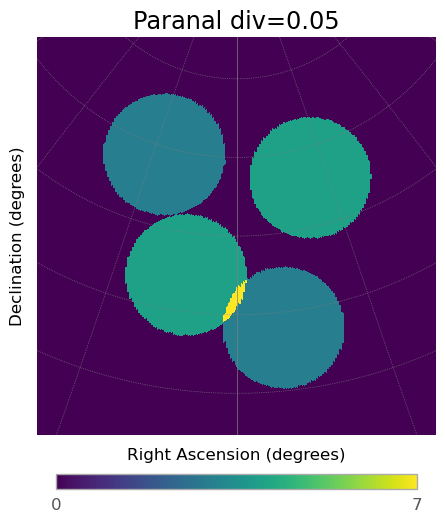

4it [00:00,  7.20it/s]
4it [00:00,  7.10it/s]


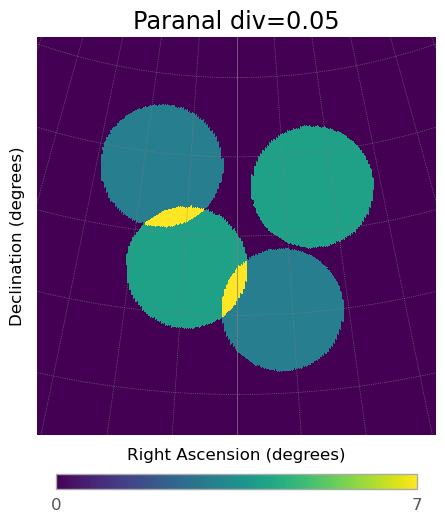

4it [00:00,  7.09it/s]
4it [00:00,  6.45it/s]


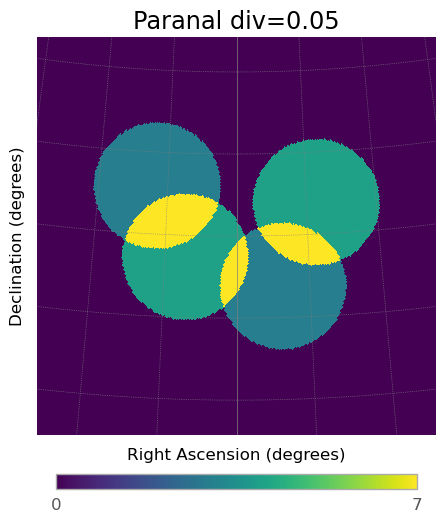

In [60]:

array_alt_1.multiplicity_plot(subarray_mult=number_of_telescopes_subarray_1 )# Set the main title for the entire figure
array_alt_2.multiplicity_plot(subarray_mult=number_of_telescopes_subarray_1 )
array_alt_3.multiplicity_plot(subarray_mult=number_of_telescopes_subarray_1 )





# SUB_ARRAY_1 DIV 2

4it [00:00,  7.32it/s]
4it [00:00,  6.94it/s]


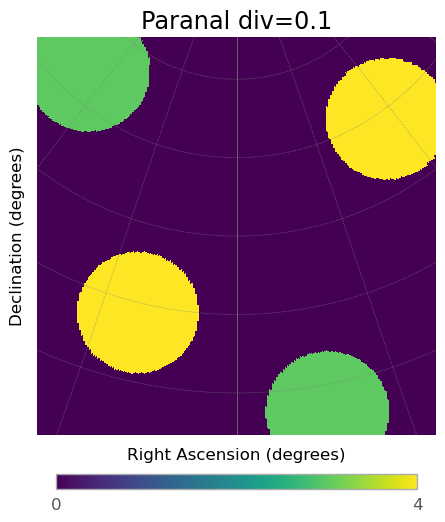

4it [00:00,  7.29it/s]
4it [00:00,  6.89it/s]


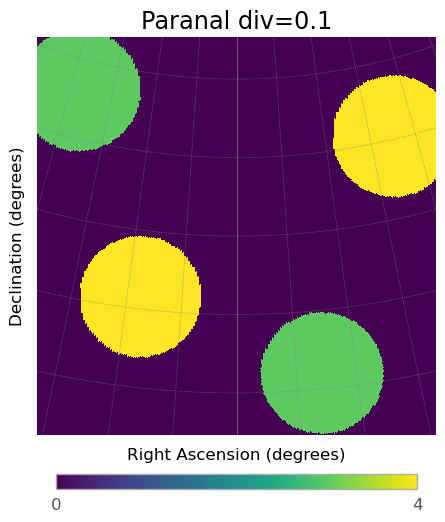

4it [00:00,  7.20it/s]
4it [00:00,  7.04it/s]


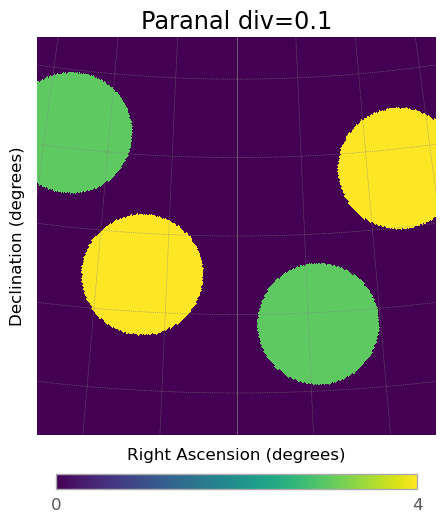

In [61]:

array_alt_1_div_2.multiplicity_plot(subarray_mult=number_of_telescopes_subarray_1 )# Set the main title for the entire figure
array_alt_2_div_2.multiplicity_plot(subarray_mult=number_of_telescopes_subarray_1 )
array_alt_3_div_2.multiplicity_plot(subarray_mult=number_of_telescopes_subarray_1 )


# SUB_ARRAY_1 DIV 3

4it [00:00,  7.26it/s]
4it [00:00,  6.93it/s]


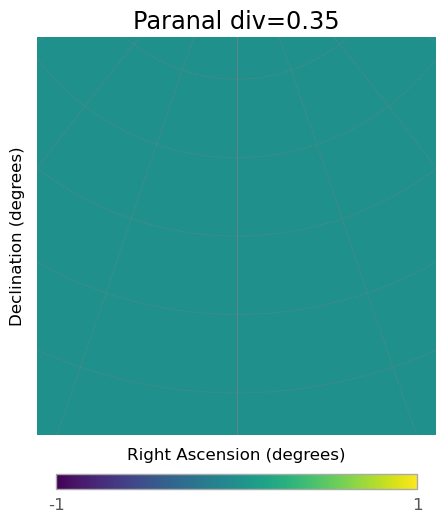

4it [00:00,  7.39it/s]
4it [00:00,  7.09it/s]


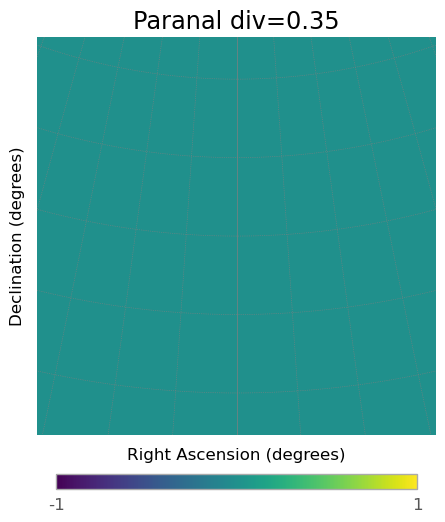

4it [00:00,  7.46it/s]
4it [00:00,  6.39it/s]


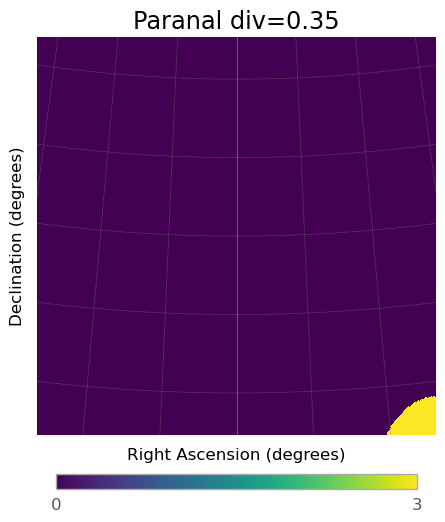

In [62]:
array_alt_1_div_3.multiplicity_plot(subarray_mult=number_of_telescopes_subarray_1 )# Set the main title for the entire figure
array_alt_2_div_3.multiplicity_plot(subarray_mult=number_of_telescopes_subarray_1 )
array_alt_3_div_3.multiplicity_plot(subarray_mult=number_of_telescopes_subarray_1 )



# SUB_ARRAY_2 DIV_1

4it [00:00,  7.30it/s]
4it [00:00,  7.05it/s]


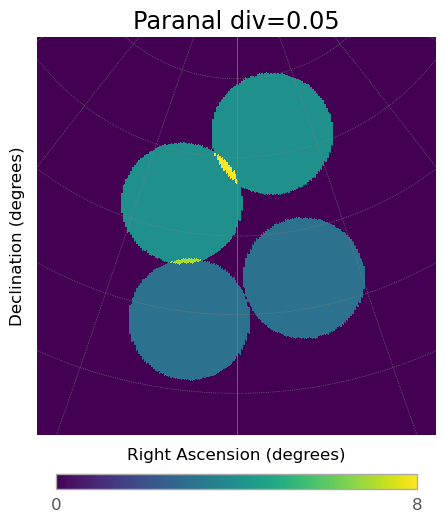

4it [00:00,  7.43it/s]
4it [00:00,  7.06it/s]


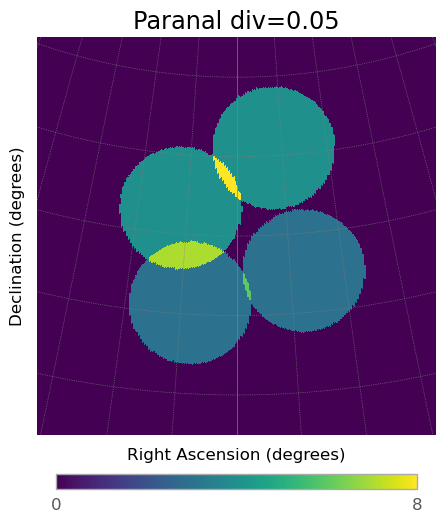

4it [00:00,  6.80it/s]
4it [00:00,  6.93it/s]


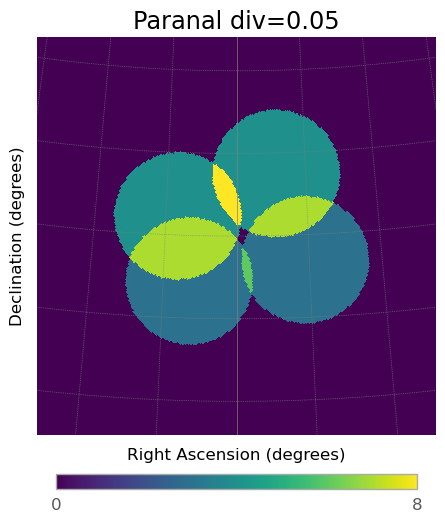

In [63]:
array_2_alt_1.multiplicity_plot(subarray_mult=number_of_telescopes_subarray_2 )# Set the main title for the entire figure
array_2_alt_2.multiplicity_plot(subarray_mult=number_of_telescopes_subarray_2 )
array_2_alt_3.multiplicity_plot(subarray_mult=number_of_telescopes_subarray_2 )



# SUB_ARRAY_2 DIV_2

4it [00:00,  7.27it/s]
4it [00:00,  6.96it/s]


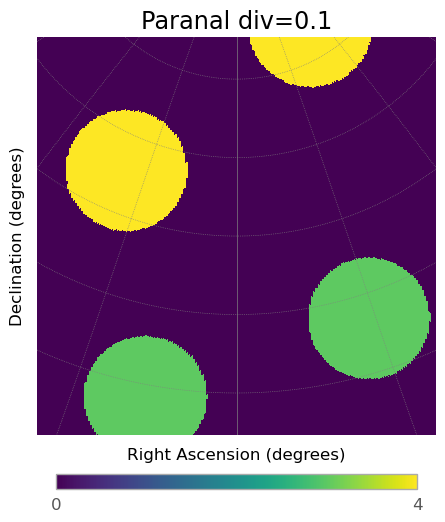

4it [00:00,  7.14it/s]
4it [00:00,  7.14it/s]


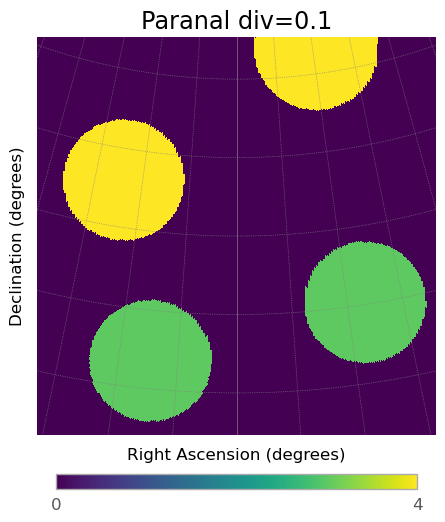

4it [00:00,  7.11it/s]
4it [00:00,  6.96it/s]


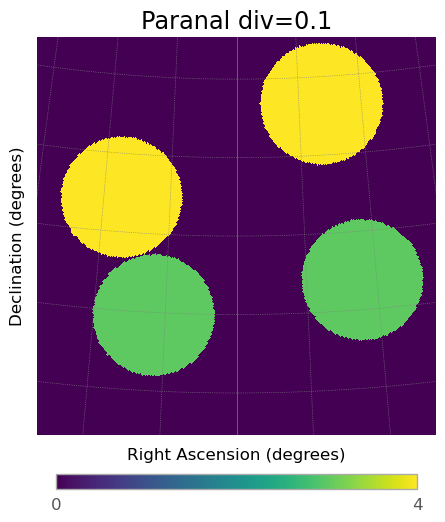

In [64]:

array_2_alt_1_div_2.multiplicity_plot(subarray_mult=number_of_telescopes_subarray_2 )# Set the main title for the entire figure
array_2_alt_2_div_2.multiplicity_plot(subarray_mult=number_of_telescopes_subarray_2 )
array_2_alt_3_div_2.multiplicity_plot(subarray_mult=number_of_telescopes_subarray_2 )


# SUB_ARRAY_2 DIV_3 

4it [00:00,  6.82it/s]
4it [00:00,  6.73it/s]


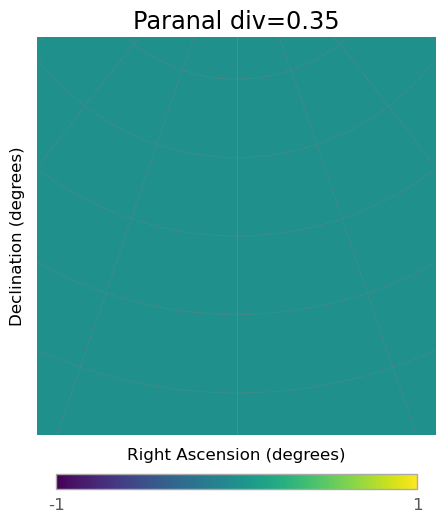

4it [00:00,  7.24it/s]
4it [00:00,  6.83it/s]


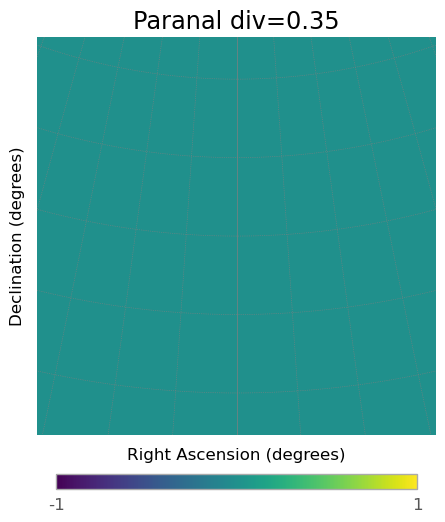

4it [00:00,  7.05it/s]
4it [00:00,  6.12it/s]


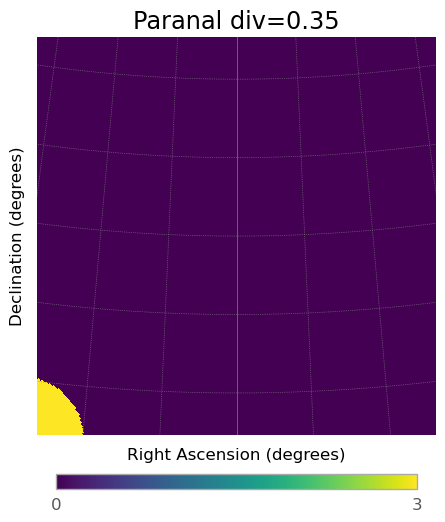

In [65]:
array_2_alt_1_div_3.multiplicity_plot(subarray_mult=number_of_telescopes_subarray_2 )# Set the main title for the entire figure
array_2_alt_2_div_3.multiplicity_plot(subarray_mult=number_of_telescopes_subarray_2 )
array_2_alt_3_div_3.multiplicity_plot(subarray_mult=number_of_telescopes_subarray_2 )


## SUBARRAY_3_DIV_1

4it [00:00,  7.26it/s]
4it [00:00,  6.93it/s]


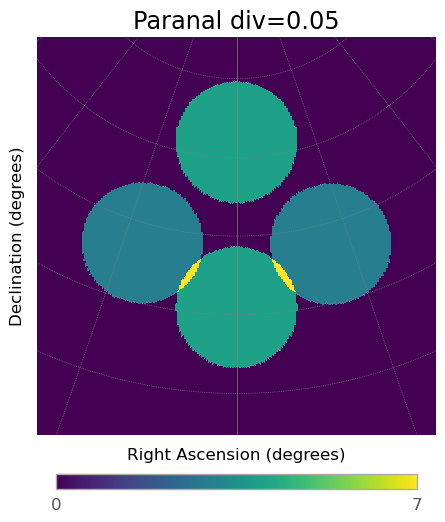

4it [00:00,  7.07it/s]
4it [00:00,  6.43it/s]


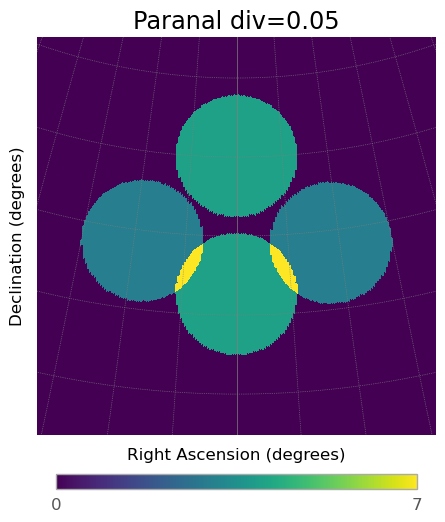

4it [00:00,  6.72it/s]
4it [00:00,  6.83it/s]


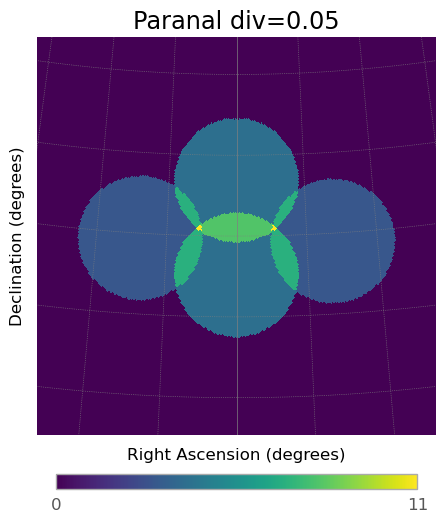

In [66]:
array_3_alt_1.multiplicity_plot(subarray_mult=number_of_telescopes_subarray_3 )# Set the main title for the entire figure
array_3_alt_2.multiplicity_plot(subarray_mult=number_of_telescopes_subarray_3 )
array_3_alt_3.multiplicity_plot(subarray_mult=number_of_telescopes_subarray_3 )



## SUBARRAY_3_DIV_2

4it [00:00,  6.66it/s]
4it [00:00,  6.97it/s]


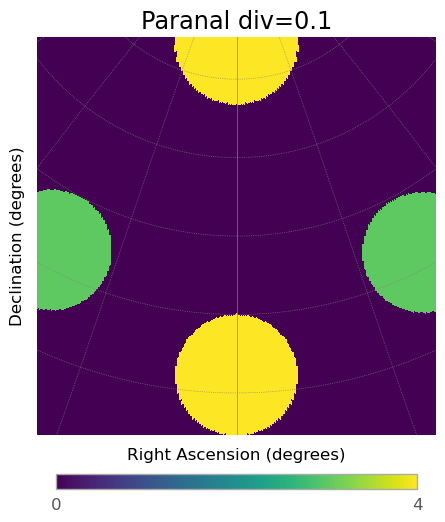

4it [00:00,  7.41it/s]
4it [00:00,  7.07it/s]


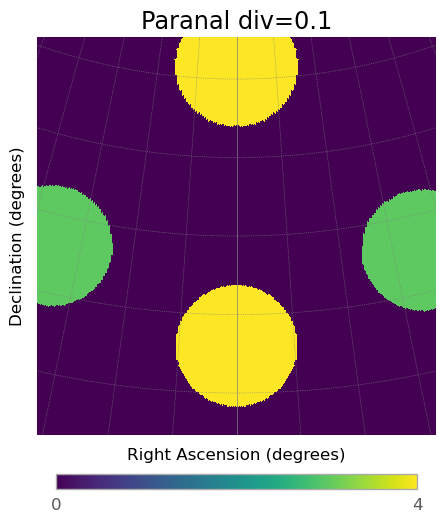

4it [00:00,  7.34it/s]
4it [00:00,  7.02it/s]


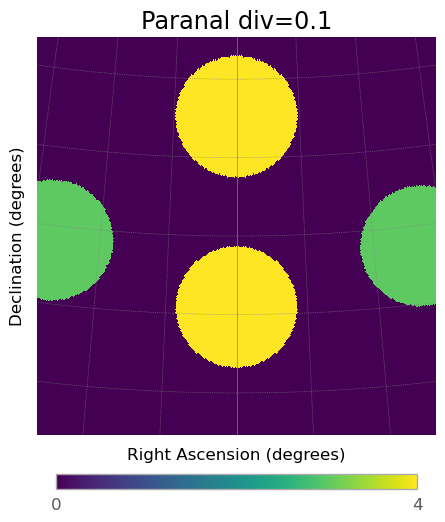

In [67]:
array_3_alt_1_div_2.multiplicity_plot(subarray_mult=number_of_telescopes_subarray_3 )# Set the main title for the entire figure
array_3_alt_2_div_2.multiplicity_plot(subarray_mult=number_of_telescopes_subarray_3 )
array_3_alt_3_div_2.multiplicity_plot(subarray_mult=number_of_telescopes_subarray_3 )


## SUBARRAY_3_DIV_3

4it [00:00,  7.26it/s]
4it [00:00,  7.01it/s]


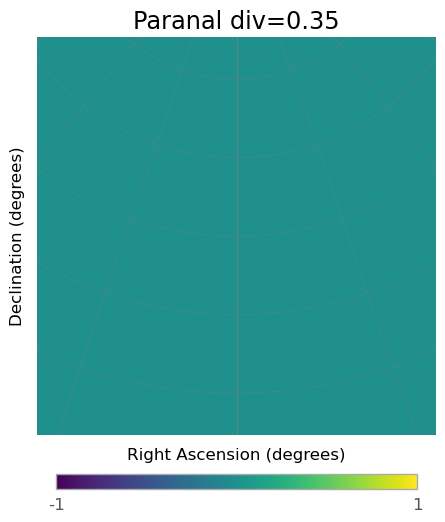

4it [00:00,  7.32it/s]
4it [00:00,  7.01it/s]


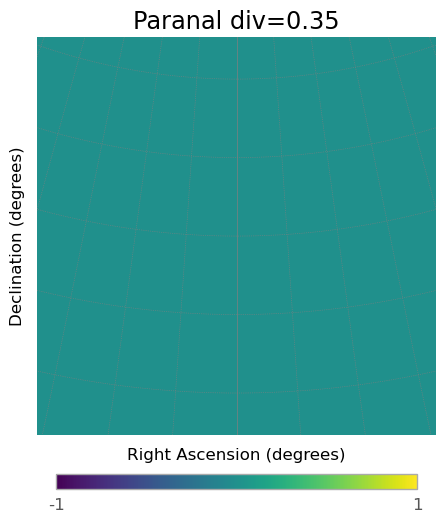

4it [00:00,  7.13it/s]
4it [00:00,  6.74it/s]


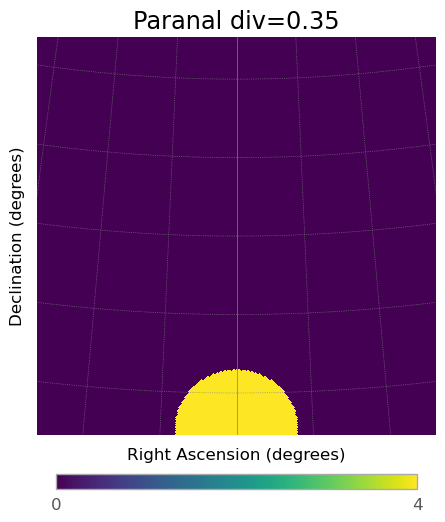

In [68]:
array_3_alt_1_div_3.multiplicity_plot(subarray_mult=number_of_telescopes_subarray_3 )# Set the main title for the entire figure
array_3_alt_2_div_3.multiplicity_plot(subarray_mult=number_of_telescopes_subarray_3 )
array_3_alt_3_div_3.multiplicity_plot(subarray_mult=number_of_telescopes_subarray_3 )


array_3_alt_1.display("xyz")
plt.title("Array of only MST subarray 20 gradi")
array_3_alt_2.display("xyz")
plt.title("Array of only MST subarray 40 gradi")
array_3_alt_3.display("xyz")
plt.title("Array of only MST subarray 60 gradi")
plt.show()

## GRAPHING MULTIPLICITY AND FOV to understand what is going on 

In [69]:
array= LoadConfig("./subarray_1_2_SOUTH.txt", frame=cta, pointing2src=True)
array_2= LoadConfig("./subarray_2_SOUTH.txt", frame=cta, pointing2src=True)
array_3= LoadConfig("./subarray_3_SOUTH.txt", frame=cta, pointing2src=True)

In [70]:
array.table

<Table length=4>
  id     x       y       z       az   ...   p_x     p_y     p_z    d_tel 
         m       m       m      rad   ...                            m   
int64 float64 float64 float64 float64 ... float64 float64 float64 float64
----- ------- ------- ------- ------- ... ------- ------- ------- -------
    1 -153.25   157.0   27.62   0.000 ...   1.000  -0.000   0.000  208.79
    2    75.0  -116.5   27.75   0.000 ...   1.000  -0.000   0.000  147.44
    3 -204.33  -159.0   33.83   0.000 ...   1.000  -0.000   0.000  241.65
    4  204.33   105.0   21.33   0.000 ...   1.000  -0.000   0.000  248.82

In [45]:
full_array.table

<Table length=14>
  id     x       y       z       az   ...   p_x     p_y     p_z    d_tel 
         m       m       m      rad   ...                            m   
int64 float64 float64 float64 float64 ... float64 float64 float64 float64
----- ------- ------- ------- ------- ... ------- ------- ------- -------
    1     0.0     0.0    24.0   0.000 ...   1.000  -0.000   0.000   22.65
    2     0.0   151.0    25.0   0.000 ...   1.000  -0.000   0.000  152.67
    3     0.0  -151.0    31.0   0.000 ...   1.000  -0.000   0.000  152.68
    4   150.0    75.0    21.0   0.000 ...   1.000  -0.000   0.000  188.09
    5   150.0   -75.0    26.0   0.000 ...   1.000  -0.000   0.000  187.98
    6   150.0   240.0    24.0   0.000 ...   1.000  -0.000   0.000  295.50
    7   150.0  -240.0    30.0   0.000 ...   1.000  -0.000   0.000  295.49
    8   313.0     0.0    19.0   0.000 ...   1.000  -0.000   0.000  335.47
    9  -150.0   -75.0    28.0   0.000 ...   1.000  -0.000   0.000  148.05
   10  -150.0    75.0    28.0   0.000 ...   1.000  -0.000   0.000  148.05
   11  -150.0  -240.0    38.5   0.000 ...   1.000  -0.000   0.000  272.05
   12  -150.0   240.0    27.0   0.000 ...   1.000  -0.000   0.000  271.83
   13  -313.0  -162.0    35.0   0.000 ...   1.000  -0.000   0.000  332.82
   14  -313.0   162.0    30.5   0.000 ...   1.000  -0.000   0.000  332.75

In [46]:
array.table

<Table length=4>
  id     x       y       z       az   ...   p_x     p_y     p_z    d_tel 
         m       m       m      rad   ...                            m   
int64 float64 float64 float64 float64 ... float64 float64 float64 float64
----- ------- ------- ------- ------- ... ------- ------- ------- -------
    1 -153.25   157.0   27.62   0.000 ...   1.000  -0.000   0.000  208.79
    2    75.0  -116.5   27.75   0.000 ...   1.000  -0.000   0.000  147.44
    3 -204.33  -159.0   33.83   0.000 ...   1.000  -0.000   0.000  241.65
    4  204.33   105.0   21.33   0.000 ...   1.000  -0.000   0.000  248.82

In [47]:
full_array.divergent_pointing(0.05, az=0,alt=70)

In [48]:
full_array.hFoV(m_cut=3)[0]

14it [00:01,  7.41it/s]


0.4589887122248568

In [49]:
full_array.hFoV()[0]

14it [00:01,  7.00it/s]


390.2715450231926

14it [00:02,  6.86it/s]
14it [00:01,  7.01it/s]


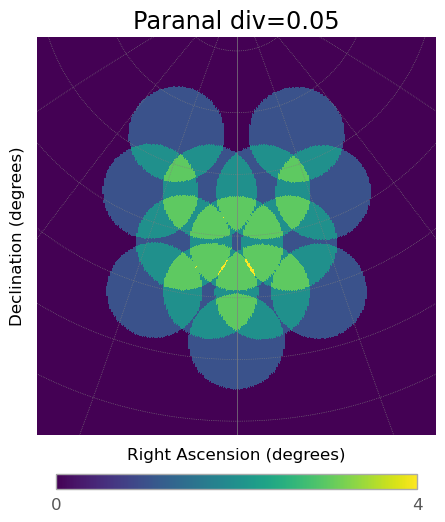

In [50]:
full_array.multiplicity_plot()

In [51]:
div=[]

div=np.linspace(0,0.4, 40)

In [52]:
FoV_full_array=[]
multiplicity_full_array=[]
for divergence in div:
    full_array.divergent_pointing(divergence, az=0,alt=70)
    FoV=full_array.hFoV(m_cut=3)[0]
    multiplicity=full_array.hFoV(m_cut=3)[1]
    FoV_full_array.append(FoV)
    multiplicity_full_array.append(multiplicity)
  

14it [00:02,  6.97it/s]
14it [00:02,  6.90it/s]
14it [00:01,  7.19it/s]
14it [00:01,  7.14it/s]
14it [00:02,  6.96it/s]
14it [00:01,  7.05it/s]
14it [00:01,  7.04it/s]
14it [00:01,  7.03it/s]
14it [00:01,  7.16it/s]
14it [00:01,  7.02it/s]
14it [00:02,  6.51it/s]
14it [00:02,  6.73it/s]
14it [00:02,  6.75it/s]
/Users/macbook/miniconda3/envs/divtel/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/macbook/miniconda3/envs/divtel/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
14it [00:01,  7.31it/s]
14it [00:02,  6.81it/s]
14it [00:01,  7.12it/s]
14it [00:01,  7.25it/s]
14it [00:01,  7.34it/s]
14it [00:01,  7.31it/s]
14it [00:01,  7.27it/s]
14it [00:01,  7.20it/s]
14it [00:01,  7.37it/s]
14it [00:01,  7.34it/s]
14it [00:01,  7.35it/s]
14it [00:01,  7.29it/s]
14it [00:01,  7.33it/s

In [53]:
array.table

<Table length=4>
  id     x       y       z       az   ...   p_x     p_y     p_z    d_tel 
         m       m       m      rad   ...                            m   
int64 float64 float64 float64 float64 ... float64 float64 float64 float64
----- ------- ------- ------- ------- ... ------- ------- ------- -------
    1 -153.25   157.0   27.62   0.000 ...   1.000  -0.000   0.000  208.79
    2    75.0  -116.5   27.75   0.000 ...   1.000  -0.000   0.000  147.44
    3 -204.33  -159.0   33.83   0.000 ...   1.000  -0.000   0.000  241.65
    4  204.33   105.0   21.33   0.000 ...   1.000  -0.000   0.000  248.82

In [54]:
FoV_array=[]
multiplicity_array=[]

for divergence in div:
    array.divergent_pointing(divergence, az=0,alt=70)
    FoV=array.hFoV(subarray_mult=number_of_telescopes_subarray_1)[0]
    multiplicity=array.hFoV(subarray_mult=number_of_telescopes_subarray_1)[1]
    FoV_array.append(FoV)
    multiplicity_array.append(multiplicity)
   

4it [00:00,  7.24it/s]
4it [00:00,  7.15it/s]
4it [00:00,  7.36it/s]
4it [00:00,  7.10it/s]
4it [00:00,  7.26it/s]
4it [00:00,  7.28it/s]
4it [00:00,  7.25it/s]
4it [00:00,  7.26it/s]
4it [00:00,  7.37it/s]
4it [00:00,  7.26it/s]
4it [00:00,  7.29it/s]
4it [00:00,  6.97it/s]
4it [00:00,  7.28it/s]
4it [00:00,  7.33it/s]
4it [00:00,  7.33it/s]
4it [00:00,  7.37it/s]
4it [00:00,  7.25it/s]
4it [00:00,  7.46it/s]
4it [00:00,  7.17it/s]
4it [00:00,  7.37it/s]
4it [00:00,  7.45it/s]
4it [00:00,  7.50it/s]
4it [00:00,  7.27it/s]
4it [00:00,  7.43it/s]
4it [00:00,  7.25it/s]
4it [00:00,  7.30it/s]
4it [00:00,  7.34it/s]
4it [00:00,  7.47it/s]
4it [00:00,  7.27it/s]
4it [00:00,  7.38it/s]
4it [00:00,  7.40it/s]
4it [00:00,  7.42it/s]
4it [00:00,  7.42it/s]
4it [00:00,  7.52it/s]
4it [00:00,  7.32it/s]
4it [00:00,  7.42it/s]
4it [00:00,  7.25it/s]
4it [00:00,  7.08it/s]
4it [00:00,  7.42it/s]
4it [00:00,  7.22it/s]
4it [00:00,  7.31it/s]
4it [00:00,  7.46it/s]
4it [00:00,  7.22it/s]
4it [00:00,

In [55]:
array_2.table

<Table length=4>
  id     x       y       z       az   ...   p_x     p_y     p_z    d_tel 
         m       m       m      rad   ...                            m   
int64 float64 float64 float64 float64 ... float64 float64 float64 float64
----- ------- ------- ------- ------- ... ------- ------- ------- -------
    1  -231.5   78.75   30.12   0.000 ...   1.000  -0.000   0.000  243.03
    2   -75.0  -116.5   30.38   0.000 ...   1.000  -0.000   0.000  140.96
    3   100.0  155.33   23.33   0.000 ...   1.000  -0.000   0.000  182.44
    4  204.33  -105.0    25.0   0.000 ...   1.000  -0.000   0.000  231.67

In [56]:
FoV_array_2=[]
multiplicity_array_2=[]
for divergence in div:
    array_2.divergent_pointing(divergence, az=0,alt=70)
    FoV=array_2.hFoV(subarray_mult=number_of_telescopes_subarray_2)[0]
    multiplicity=array_2.hFoV(subarray_mult=number_of_telescopes_subarray_2)[1]
    FoV_array_2.append(FoV)
    multiplicity_array_2.append(multiplicity)
     

4it [00:00,  7.13it/s]
4it [00:00,  7.24it/s]
4it [00:00,  7.36it/s]
4it [00:00,  7.23it/s]
4it [00:00,  7.31it/s]
4it [00:00,  7.35it/s]
4it [00:00,  7.28it/s]
4it [00:00,  7.38it/s]
4it [00:00,  7.17it/s]
4it [00:00,  7.38it/s]
4it [00:00,  7.33it/s]
4it [00:00,  7.31it/s]
4it [00:00,  7.08it/s]
4it [00:00,  7.27it/s]
4it [00:00,  7.29it/s]
4it [00:00,  7.41it/s]
4it [00:00,  7.12it/s]
4it [00:00,  7.40it/s]
4it [00:00,  7.43it/s]
4it [00:00,  7.54it/s]
4it [00:00,  7.49it/s]
4it [00:00,  7.52it/s]
4it [00:00,  7.45it/s]
4it [00:00,  7.36it/s]
4it [00:00,  7.43it/s]
4it [00:00,  7.46it/s]
4it [00:00,  7.33it/s]
4it [00:00,  7.28it/s]
4it [00:00,  7.39it/s]
4it [00:00,  7.51it/s]
4it [00:00,  7.33it/s]
4it [00:00,  7.12it/s]
4it [00:00,  7.50it/s]
4it [00:00,  7.36it/s]
4it [00:00,  7.31it/s]
4it [00:00,  7.48it/s]
4it [00:00,  7.49it/s]
4it [00:00,  7.50it/s]
4it [00:00,  7.19it/s]
4it [00:00,  7.56it/s]
4it [00:00,  7.44it/s]
4it [00:00,  7.39it/s]
4it [00:00,  7.02it/s]
4it [00:00,

In [57]:
# SUBARRAY 3 
FoV_array_3=[]
multiplicity_array_3=[]
for divergence in div:
    array_3.divergent_pointing(divergence, az=0,alt=70)
    FoV_3=array_3.hFoV(subarray_mult=number_of_telescopes_subarray_3)[0]
    multiplicity_3=array_3.hFoV(subarray_mult=number_of_telescopes_subarray_3)[1]
    FoV_array_3.append(FoV_3)
    multiplicity_array_3.append(multiplicity_3)
     

4it [00:00,  7.21it/s]
4it [00:00,  7.15it/s]
4it [00:00,  7.26it/s]
4it [00:00,  7.31it/s]
4it [00:00,  7.27it/s]
4it [00:00,  7.11it/s]
4it [00:00,  7.31it/s]
4it [00:00,  7.41it/s]
4it [00:00,  7.15it/s]
4it [00:00,  7.13it/s]
4it [00:00,  6.97it/s]
4it [00:00,  7.43it/s]
4it [00:00,  7.26it/s]
4it [00:00,  7.28it/s]
4it [00:00,  7.19it/s]
4it [00:00,  7.27it/s]
4it [00:00,  7.22it/s]
4it [00:00,  7.41it/s]
4it [00:00,  7.36it/s]
4it [00:00,  7.39it/s]
4it [00:00,  7.39it/s]
4it [00:00,  7.32it/s]
4it [00:00,  7.30it/s]
4it [00:00,  7.52it/s]
4it [00:00,  7.44it/s]
4it [00:00,  7.36it/s]
4it [00:00,  7.32it/s]
4it [00:00,  7.40it/s]
4it [00:00,  7.17it/s]
4it [00:00,  7.40it/s]
4it [00:00,  7.05it/s]
4it [00:00,  7.56it/s]
4it [00:00,  7.25it/s]
4it [00:00,  7.41it/s]
4it [00:00,  7.26it/s]
4it [00:00,  7.43it/s]
4it [00:00,  7.15it/s]
4it [00:00,  7.38it/s]
4it [00:00,  7.50it/s]
4it [00:00,  7.43it/s]
4it [00:00,  7.52it/s]
4it [00:00,  7.53it/s]
4it [00:00,  7.45it/s]
4it [00:00,

In [58]:
print(len(div), len(FoV_full_array), len(FoV_array))

40 40 40


In [59]:
## First to start understanding what is going on I wanted to graph in the 4 plots together 

In [60]:
FoV_array

[46.42342975074266,
 75.91673300199132,
 109.30488332554805,
 145.10600287908687,
 175.76644885570732,
 185.27407218036507,
 186.1527077151955,
 186.16582167840193,
 186.12647978878266,
 186.21827753122764,
 186.4674428321497,
 186.2051635680212,
 186.16582167840193,
 185.95599826709915,
 186.21827753122764,
 186.4674428321497,
 186.23139149443406,
 186.29696131046617,
 186.1527077151955,
 186.13959375198908,
 186.19204960481477,
 186.16582167840193,
 186.21827753122764,
 185.9297703406863,
 186.19204960481477,
 186.11336582557624,
 186.33630320008544,
 186.11336582557624,
 186.2576194208469,
 186.19204960481477,
 186.45432886894326,
 186.10025186236982,
 186.06090997275052,
 186.1527077151955,
 186.11336582557624,
 186.07402393595697,
 186.11336582557624,
 186.17893564160835,
 186.19204960481477,
 186.37564508970473]

In [61]:
FoV_array_2

[46.42342975074266,
 73.9234105946148,
 104.97727546742797,
 138.2080582325076,
 170.70445905802748,
 185.69371900297065,
 185.96911223030557,
 186.37564508970473,
 186.19204960481477,
 186.21827753122764,
 186.19204960481477,
 186.32318923687902,
 186.3625311264983,
 186.23139149443406,
 186.21827753122764,
 186.28384734725975,
 186.06090997275052,
 186.27073338405333,
 186.1527077151955,
 186.27073338405333,
 186.3100752736726,
 186.2051635680212,
 186.10025186236982,
 186.2051635680212,
 186.3100752736726,
 186.2576194208469,
 186.16582167840193,
 186.2051635680212,
 186.42810094253042,
 186.19204960481477,
 186.19204960481477,
 186.32318923687902,
 186.16582167840193,
 186.0477960095441,
 186.28384734725975,
 186.11336582557624,
 186.38875905291115,
 186.16582167840193,
 186.28384734725975,
 186.13959375198908]

In [62]:
number_of_telescopes_subarray_2

[4, 4, 3, 3]

In [63]:
number_of_telescopes_subarray_3

[4, 3, 4, 3]

## PENSAR COMO AUTOMIZAR LO SIGUIENTE EL FOV CHE STUDIO TIENE QUE SER SI O SI DEL FULL ARRAY CON EL MINIMO DEL ARRAY DE TELESCOPIOS QUE TENGO PRARA PODER CONFRONTAR MEJOR. En cambio no poner ningun limite para los subarrays

In [64]:
number_of_telescopes_subarray_1

[4, 4, 3, 3]

# hFoV and multiplicities graphs 

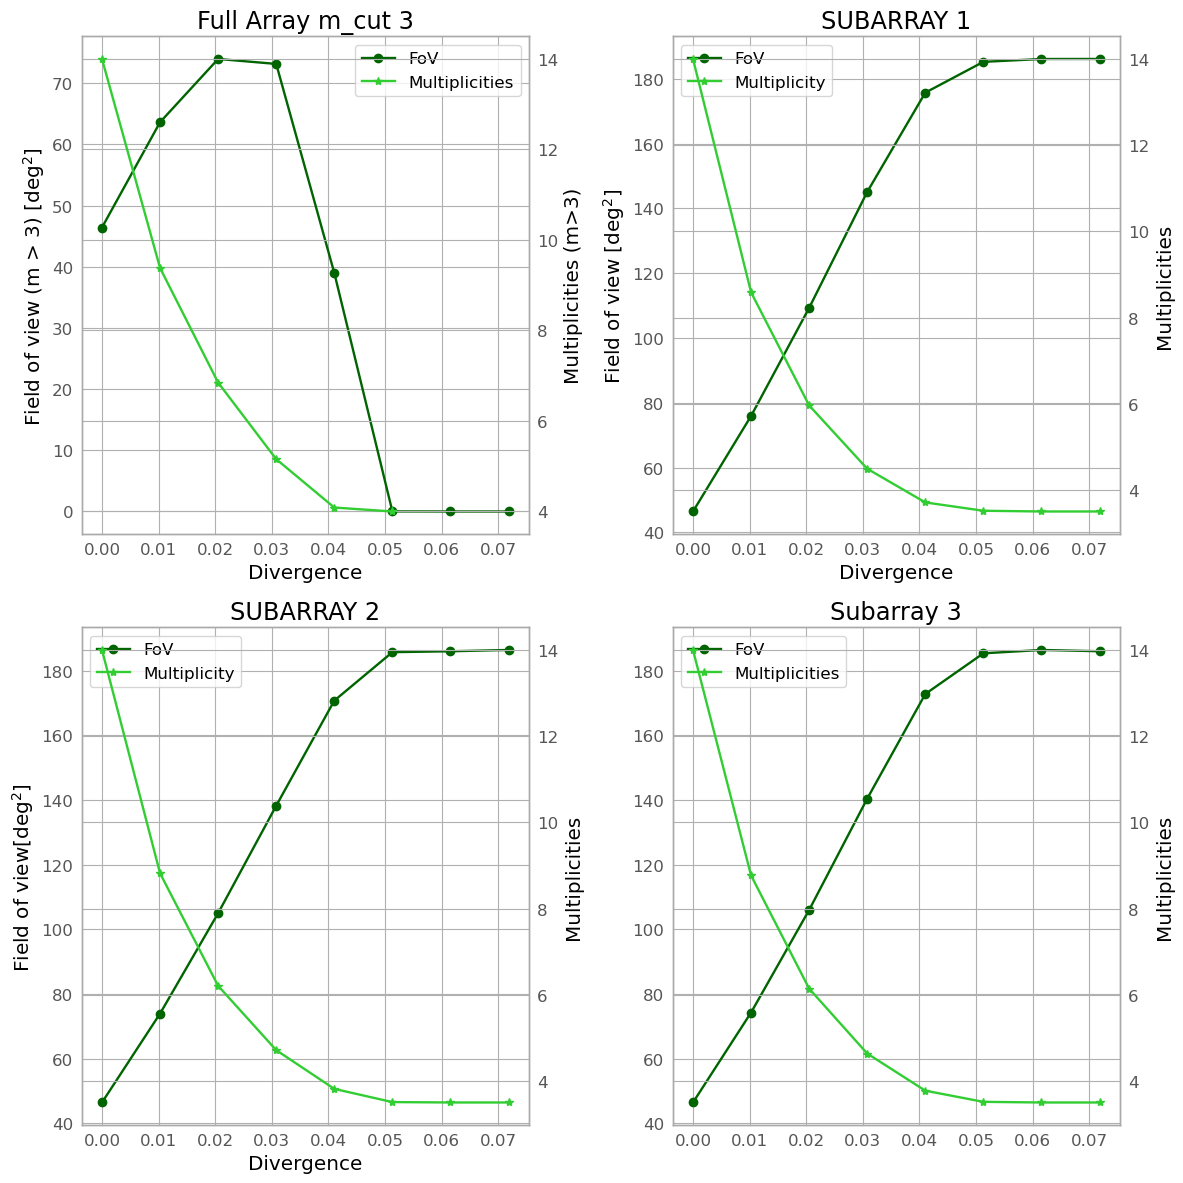

In [65]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12)) 
# Plot Full Array
# Full Array with m_cut = 3
l1=axes[0,0].plot(div[:8], FoV_full_array[:8], label='FoV', marker='o', color='darkgreen')
ax2 = axes[0,0].twinx()
l2=ax2.plot(div[:8], multiplicity_full_array[:8], label='Multiplicities',marker='*', color='limegreen')
axes[0,0].set_title('Full Array m_cut 3')
axes[0,0].set_xlabel('Divergence')
axes[0,0].set_ylabel('Field of view (m > 3) [deg$^2$]')
ax2.set_ylabel('Multiplicities (m>3)')
axeslegend = l1+l2
axes[0,0].legend(axeslegend, [l.get_label() for l in axeslegend])



#Plot the ones for subarray 1
l1=axes[0,1].plot(div[:8], FoV_array[:8], label='FoV',marker='o', color='darkgreen')
ax5=axes[0,1].twinx()
l2=ax5.plot(div[:8], multiplicity_array[:8], label='Multiplicity', marker='*', color='limegreen')
axes[0,1].set_title('SUBARRAY 1')
axes[0,1].set_xlabel('Divergence')
axes[0,1].set_ylabel('Field of view [deg$^2$]')
ax5.set_ylabel('Multiplicities')
axeslegend = l1+l2
axes[0,1].legend(axeslegend, [l.get_label() for l in axeslegend])
#Plot the ones for subarray 2
l1=axes[1,0].plot(div[:8], FoV_array_2[:8], label='FoV',marker='o', color='darkgreen')
ax5=axes[1,0].twinx()
l2=ax5.plot(div[:8], multiplicity_array_2[:8], label='Multiplicity', marker='*', color='limegreen')
axes[1,0].set_title('SUBARRAY 2')
axes[1,0].set_xlabel('Divergence')
axes[1,0].set_ylabel('Field of view[deg$^2$]')
ax5.set_ylabel('Multiplicities')
axeslegend = l1+l2
axes[1,0].legend(axeslegend, [l.get_label() for l in axeslegend])

# Subarray 3
l1=axes[1,1].plot(div[:8], FoV_array_3[:8], label='FoV',marker='o', color='darkgreen')
ax3 = axes[1,1].twinx()
l2=ax3.plot(div[:8],multiplicity_array_3[:8], label='Multiplicities', marker='*', color='limegreen')
plt.title('Subarray 3')
plt.xlabel('Divergence')
plt.ylabel('Field of view  [deg$^2$]')
plt.ylabel('Multiplicities')
axeslegend = l1+l2
axes[1,1].legend(axeslegend, [l.get_label() for l in axeslegend])
# Adjust layout
plt.tight_layout()



plt.show()

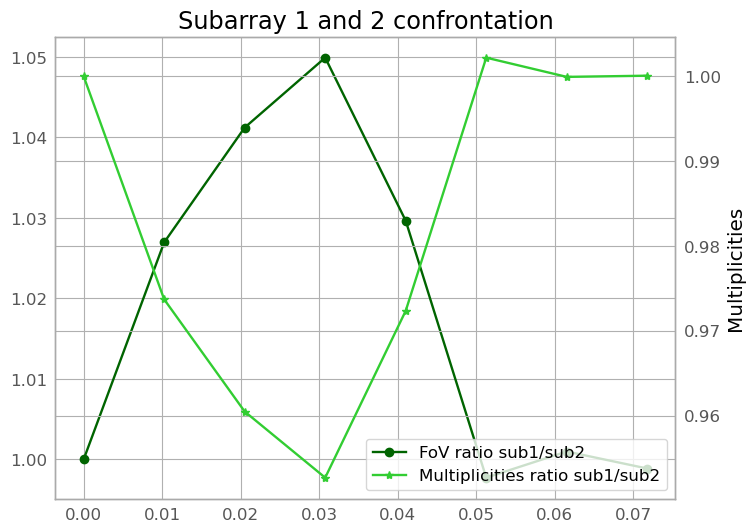

In [93]:
l1=plt.plot(div[:8], FoV_array[:8]/FoV_array_2[:8], label='FoV ratio sub1/sub2',marker='o', color='darkgreen')
ax3 = plt.twinx()
l2=ax3.plot(div[:8],multiplicity_array[:8]/multiplicity_array_2[:8], label='Multiplicities ratio sub1/sub2', marker='*', color='limegreen')
plt.title('Subarray 1 and 2 confrontation')
plt.xlabel('Divergence')
plt.ylabel('Field of view  [deg$^2$]')
plt.ylabel('Multiplicities')
axeslegend = l1+l2
plt.legend(axeslegend, [l.get_label() for l in axeslegend])
plt.show()

In [66]:
#mask[:100]
multiplicity_full_array

[14.0,
 9.37976509375644,
 6.847544761567098,
 5.155941925076179,
 4.087117389841911,
 4.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

In [67]:
 FoV_full_array

[46.42342975074266,
 63.642063440778,
 73.9758664474405,
 73.16280072864218,
 38.98781261269998,
 0.013113963206424481,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

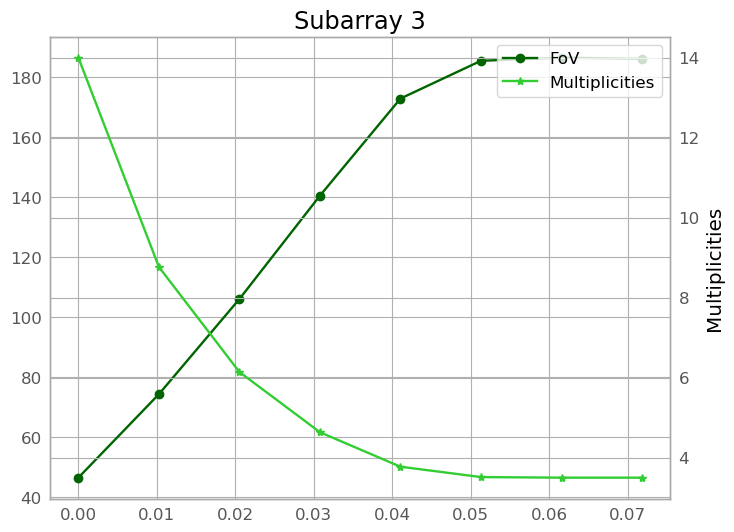

In [68]:
# Plot array 3

l1=plt.plot(div[:8], FoV_array_3[:8], label='FoV',marker='o', color='darkgreen')
ax3 = plt.twinx()
l2=ax3.plot(div[:8],multiplicity_array_3[:8], label='Multiplicities', marker='*', color='limegreen')
plt.title('Subarray 3')
plt.xlabel('Divergence')
plt.ylabel('Field of view  [deg$^2$]')
plt.ylabel('Multiplicities')
axeslegend = l1+l2
plt.legend(axeslegend, [l.get_label() for l in axeslegend])
plt.show()

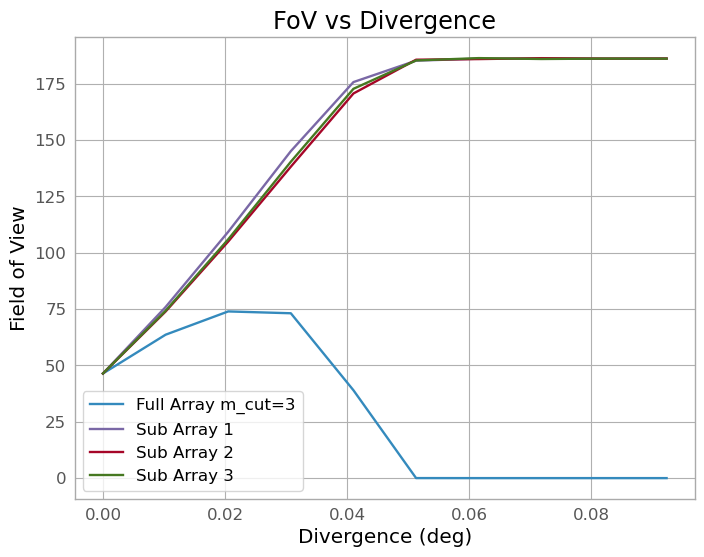

In [69]:
plt.plot(div[:10], FoV_full_array[:10], label='Full Array m_cut=3')

plt.plot(div[:10], FoV_array[:10], label='Sub Array 1')
plt.plot(div[:10], FoV_array_2[:10], label='Sub Array 2')
plt.plot(div[:10], FoV_array_3[:10], label='Sub Array 3')
# Add labels and title
plt.xlabel("Divergence (deg)")  
plt.ylabel("Field of View")  
plt.title("FoV vs Divergence")  

# Add legend
plt.legend()

# Display the plot
plt.show()

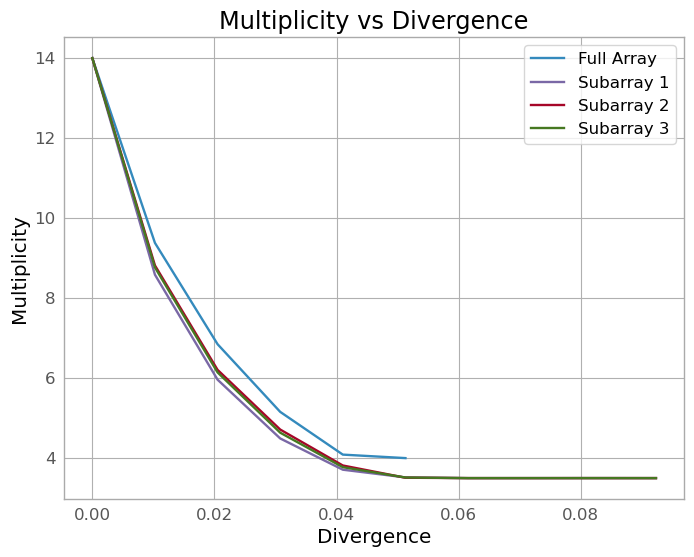

In [70]:
plt.plot(div[:10], multiplicity_full_array[:10], label='Full Array')
plt.plot(div[:10],  multiplicity_array[:10], label='Subarray 1')
plt.plot(div[:10],  multiplicity_array_2[:10], label='Subarray 2')
plt.plot(div[:10],  multiplicity_array_3[:10], label='Subarray 3')
plt.xlabel("Divergence")  
plt.ylabel("Multiplicity")  # Y-axis label
plt.title("Multiplicity vs Divergence")  # Title of the plot
plt.legend()
plt.show()

In [71]:
print(f"The FoV difference between subarray 1 and 2", np.mean(FoV_array)/np.mean(FoV_array_2))
print(f"The FoV difference between subarray 2 and 3", np.mean(FoV_array_2)/np.mean(FoV_array_3))
print(f"The FoV difference between subarray 1 and 3", np.mean(FoV_array)/np.mean(FoV_array_3))
print(f"The FoV differenve between subarray 1 and the full array m_cut=3 is", np.mean(FoV_full_array)/np.mean(FoV_array) )
print(f"The FoV differenve between subarray 2 and the full array m_cut=3 is", np.mean(FoV_full_array)/np.mean(FoV_array_2) )
print(f"The FoV differenve between subarray 3 and the full array m_cut=3 is", np.mean(FoV_full_array)/np.mean(FoV_array_3) )

The FoV difference between subarray 1 and 2 1.0023748772577141
The FoV difference between subarray 2 and 3 0.9994795461642552
The FoV difference between subarray 1 and 3 1.0018531874079912
The FoV differenve between subarray 1 and the full array m_cut=3 is 0.04190623556324897
The FoV differenve between subarray 2 and the full array m_cut=3 is 0.04200575772904454
The FoV differenve between subarray 3 and the full array m_cut=3 is 0.04198389567131109


In [72]:
FoV_array = np.array(FoV_array)
FoV_array_2 = np.array(FoV_array_2)
#FoV_mult_cut_2_array = np.array(FoV_full_array_mult_cut_2)
FoV_array_3=np.array(FoV_array_3)

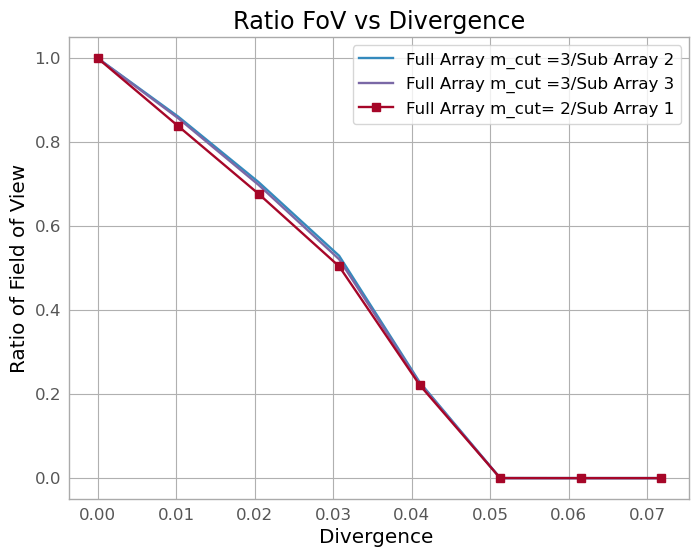

In [73]:


plt.plot(div[:8], FoV_full_array[:8]/FoV_array_2[:8], label='Full Array m_cut =3/Sub Array 2')
plt.plot(div[:8], FoV_full_array[:8]/FoV_array_3[:8], label='Full Array m_cut =3/Sub Array 3')
plt.plot(div[:8], FoV_full_array[:8]/FoV_array[:8], label='Full Array m_cut= 2/Sub Array 1', marker='s')

plt.xlabel("Divergence ")  
plt.ylabel("Ratio of Field of View")  
plt.title("Ratio FoV vs Divergence")  
plt.legend()

plt.show()

In [74]:
#hfov = hp.nside2pixarea(nside, True)*np.sum(mask_fov)
multiplicity_full_array[:10]

[14.0,
 9.37976509375644,
 6.847544761567098,
 5.155941925076179,
 4.087117389841911,
 4.0,
 nan,
 nan,
 nan,
 nan]

In [75]:
multiplicity_full_array = np.array(multiplicity_full_array)
multiplicity_array_2 = np.array(multiplicity_array_2)
multiplicity_array_3 = np.array(multiplicity_array_3)
multiplicity_array = np.array(multiplicity_array)
#multiplicity_full_array_mult_2 = np.array(multiplicity_full_array_mult_cut_2)

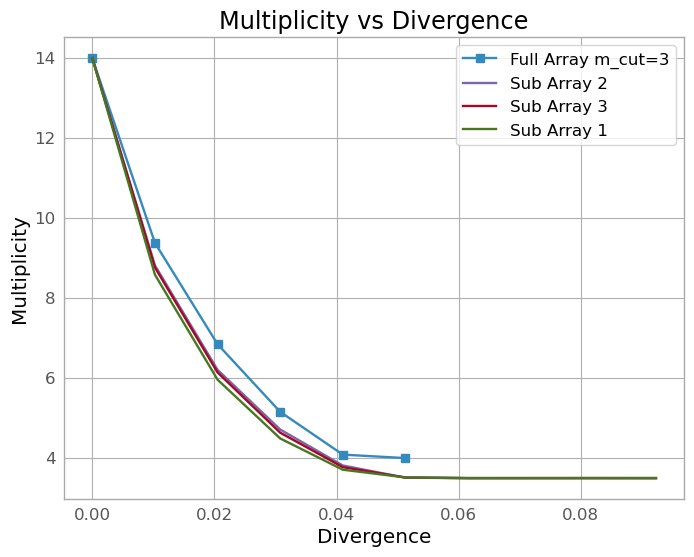

In [76]:
plt.plot(div[:10], multiplicity_full_array[:10], label='Full Array m_cut=3', marker='s')
plt.plot(div[:10],  multiplicity_array_2[:10], label='Sub Array 2')
plt.plot(div[:10],  multiplicity_array_3[:10], label='Sub Array 3')
plt.plot(div[:10],  multiplicity_array[:10], label='Sub Array 1')
#plt.plot(div[:10],  multiplicity_full_array_mult_cut_2[:10], label='Full Array m_cut=2', marker='s')
plt.xlabel("Divergence")  
plt.ylabel("Multiplicity")  # Y-axis label
plt.title("Multiplicity vs Divergence")  # Title of the plot
plt.legend()
plt.show()

In [77]:
print(np.mean(multiplicity_array_2)/np.mean(multiplicity_array))

1.0050322800697258


In [78]:
multiplicity_full_array[:10]

array([14.        ,  9.37976509,  6.84754476,  5.15594193,  4.08711739,
        4.        ,         nan,         nan,         nan,         nan])

In [79]:
multiplicity_array[:10]

array([14.        ,  8.5849024 ,  5.96076785,  4.49109806,  3.70991569,
        3.5167752 ,  3.49975343,  3.50007044,  3.50045797,  3.49978873])

In [80]:
multiplicity_array_2[:10]

array([14.        ,  8.8167465 ,  6.20599625,  4.7141095 ,  3.81539525,
        3.50911017,  3.50003526,  3.49985927,  3.50042259,  3.50007042])

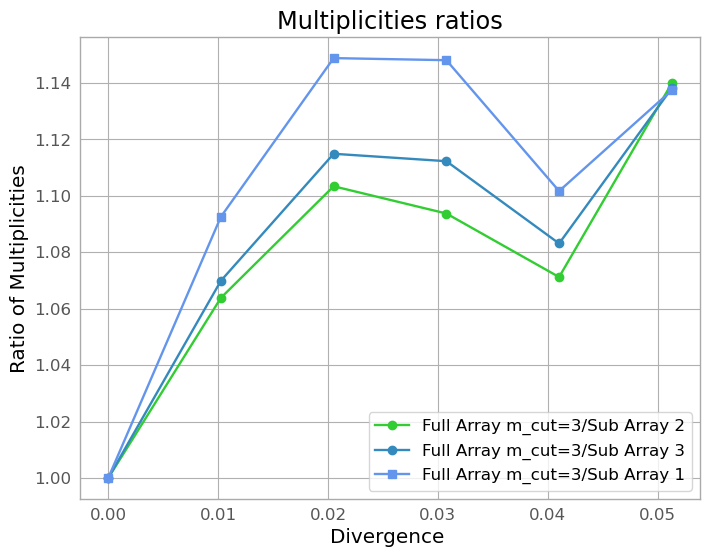

In [81]:
#plt.plot(div[:12], multiplicity_full_array[:12]/multiplicity_array[:12], label='Full Array m_cut=3/Sub Array 1', color='blue', marker='s')
plt.plot(div[:12], multiplicity_full_array[:12]/multiplicity_array_2[:12], label='Full Array m_cut=3/Sub Array 2', color='limegreen', marker='o')
plt.plot(div[:12], multiplicity_full_array[:12]/multiplicity_array_3[:12], label='Full Array m_cut=3/Sub Array 3', marker='o')
plt.plot(div[:12], multiplicity_full_array[:12]/multiplicity_array[:12], label='Full Array m_cut=3/Sub Array 1', color='cornflowerblue', marker='s')
#plt.plot(div[:12], multiplicity_full_array_mult_cut_2[:12]/multiplicity_array_2[:12], label='Full Array m_cut=2/Sub Array 2', color='darkgreen', marker='o')

plt.xlabel("Divergence ")  
plt.ylabel("Ratio of Multiplicities")  
plt.title("Multiplicities ratios")  
plt.legend()

plt.show()
#print(multiplicity_full_array[5])
#print(multiplicity_array[5])
#1.62/4.15

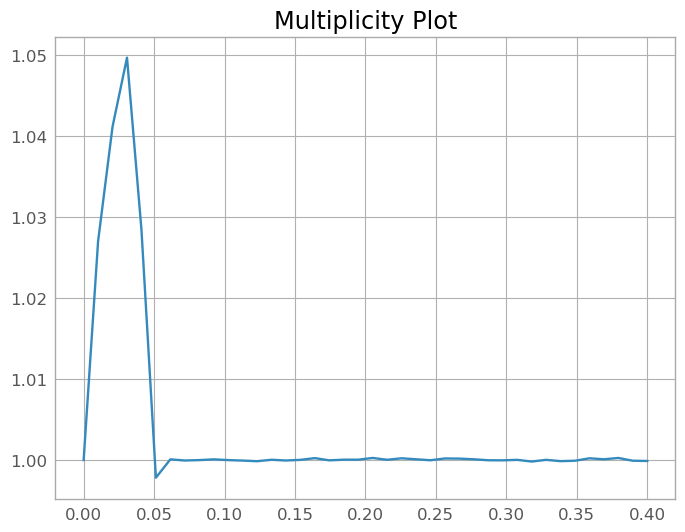

In [82]:
plt.plot(div, multiplicity_array_2/multiplicity_array)
plt.title('Multiplicity Plot')
plt.show()

4it [00:00,  6.81it/s]
4it [00:00,  6.58it/s]


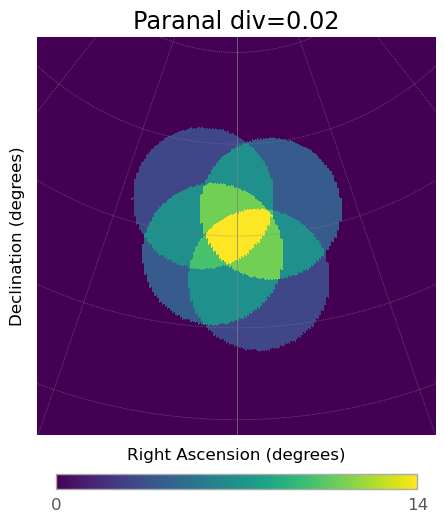

4it [00:00,  7.39it/s]
4it [00:00,  6.65it/s]


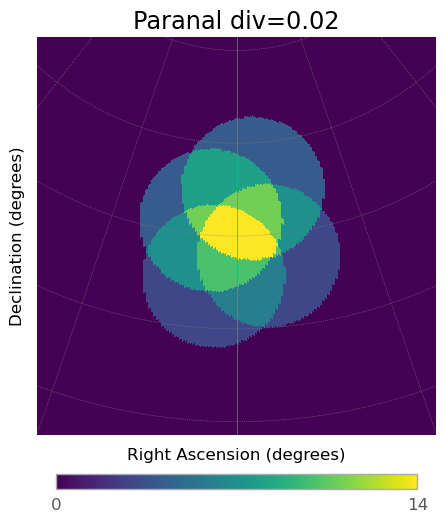

4it [00:00,  6.78it/s]
4it [00:00,  6.15it/s]


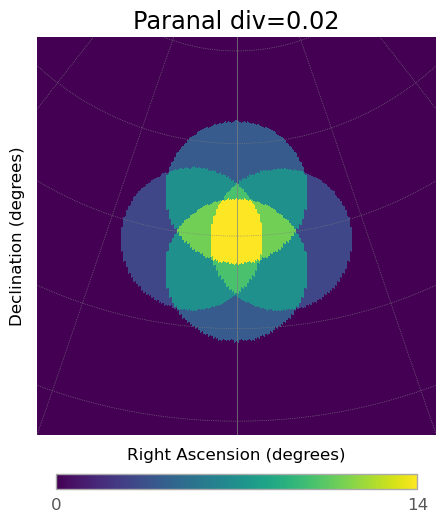

In [94]:
array.divergent_pointing(div=0.02, az=0, alt=70)
array.multiplicity_plot(number_of_telescopes_subarray_1)
array_2.divergent_pointing(div=0.02, az=0, alt=70)
array_2.multiplicity_plot(number_of_telescopes_subarray_2)
array_3.divergent_pointing(div=0.02, az=0, alt=70)
array_3.multiplicity_plot(number_of_telescopes_subarray_3)

4it [00:00,  6.58it/s]
4it [00:00,  6.74it/s]


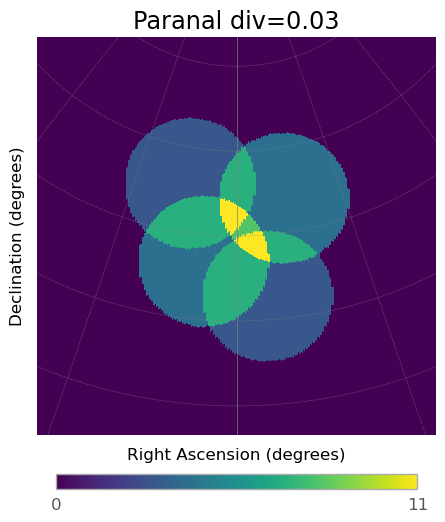

4it [00:00,  7.22it/s]
4it [00:00,  6.29it/s]


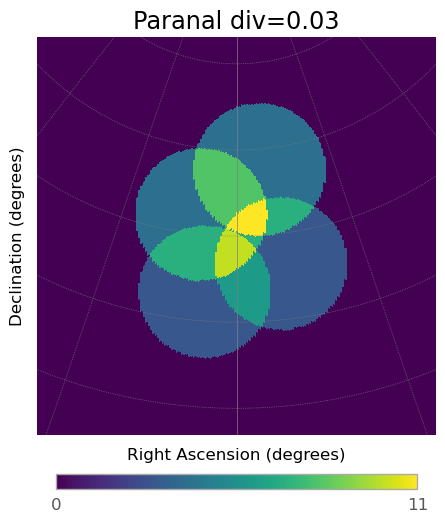

4it [00:00,  7.11it/s]
4it [00:00,  6.33it/s]


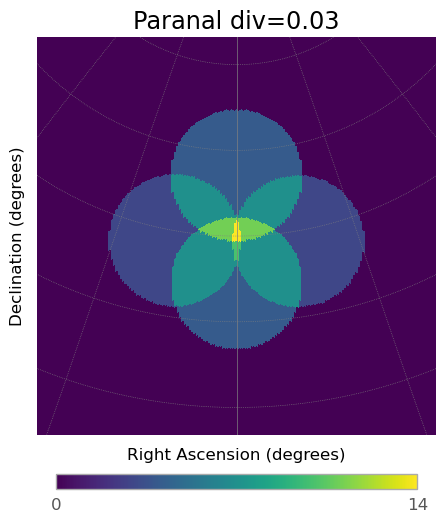

In [95]:
array.divergent_pointing(div=0.03, az=0, alt=70)
array.multiplicity_plot(number_of_telescopes_subarray_1)
array_2.divergent_pointing(div=0.03, az=0, alt=70)
array_2.multiplicity_plot(number_of_telescopes_subarray_2)
array_3.divergent_pointing(div=0.03, az=0, alt=70)
array_3.multiplicity_plot(number_of_telescopes_subarray_3)

4it [00:00,  6.66it/s]
4it [00:00,  6.51it/s]


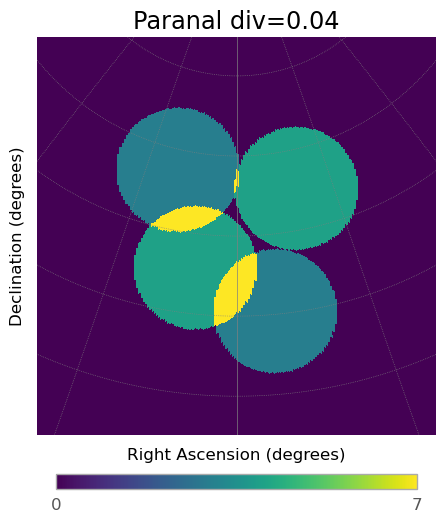

4it [00:00,  7.01it/s]
4it [00:00,  6.23it/s]


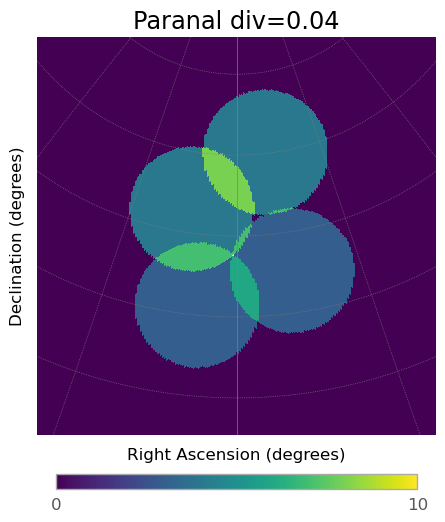

4it [00:00,  7.00it/s]
4it [00:00,  6.36it/s]


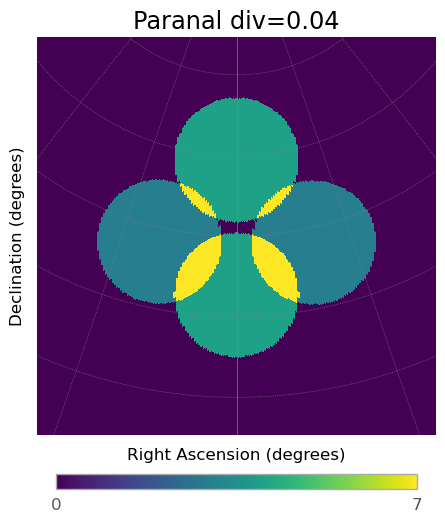

In [96]:
array.divergent_pointing(div=0.04, az=0, alt=70)
array.multiplicity_plot(number_of_telescopes_subarray_1)
array_2.divergent_pointing(div=0.04, az=0, alt=70)
array_2.multiplicity_plot(number_of_telescopes_subarray_2)
array_3.divergent_pointing(div=0.04, az=0, alt=70)
array_3.multiplicity_plot(number_of_telescopes_subarray_3)

4it [00:00,  6.86it/s]
4it [00:00,  6.63it/s]


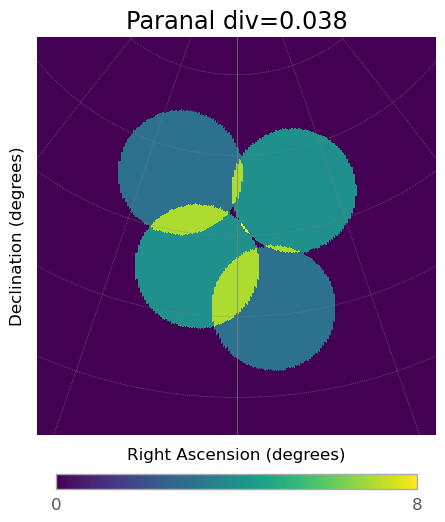

4it [00:00,  6.74it/s]
4it [00:00,  5.86it/s]


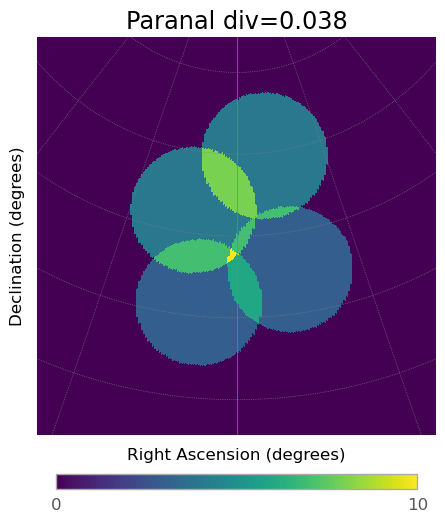

4it [00:00,  6.96it/s]
4it [00:00,  6.07it/s]


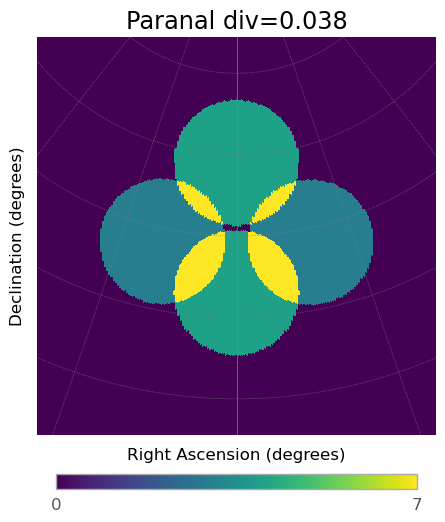

In [102]:
array.divergent_pointing(div=0.038, az=0, alt=70)
array.multiplicity_plot(number_of_telescopes_subarray_1)
array_2.divergent_pointing(div=0.038, az=0, alt=70)
array_2.multiplicity_plot(number_of_telescopes_subarray_2)
array_3.divergent_pointing(div=0.038, az=0, alt=70)
array_3.multiplicity_plot(number_of_telescopes_subarray_3)

## SHOWING WHAT HAPPENS RUGHT AFTER 0.05 

4it [00:00,  6.91it/s]
4it [00:00,  6.83it/s]


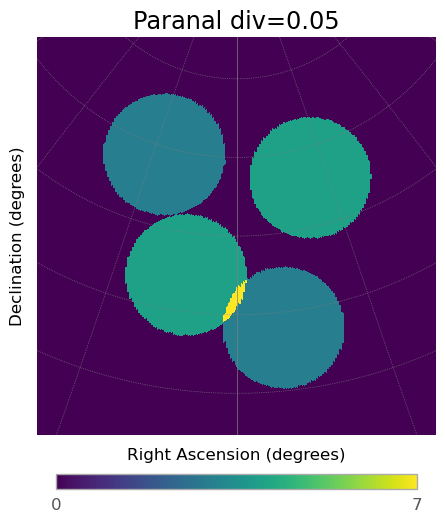

4it [00:00,  7.33it/s]
4it [00:00,  6.88it/s]


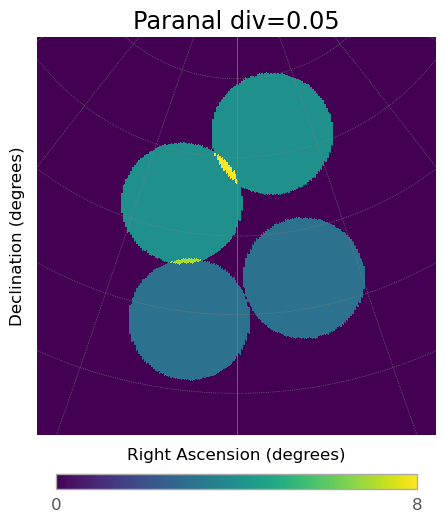

4it [00:00,  7.37it/s]
4it [00:00,  7.08it/s]


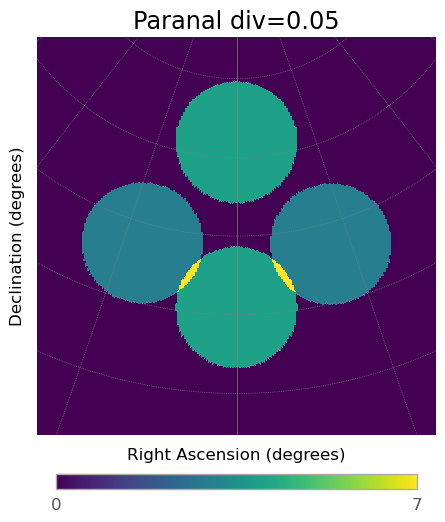

In [83]:
array.divergent_pointing(div=0.05, az=0, alt=70)
array.multiplicity_plot(number_of_telescopes_subarray_1)
array_2.divergent_pointing(div=0.05, az=0, alt=70)
array_2.multiplicity_plot(number_of_telescopes_subarray_2)
array_3.divergent_pointing(div=0.05, az=0, alt=70)
array_3.multiplicity_plot(number_of_telescopes_subarray_3)

4it [00:00,  7.38it/s]
4it [00:00,  6.60it/s]


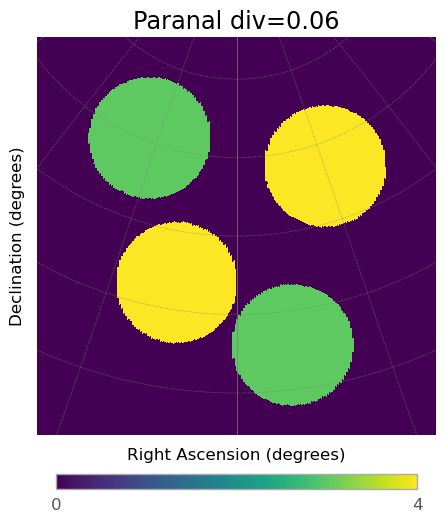

4it [00:00,  7.26it/s]
4it [00:00,  6.73it/s]


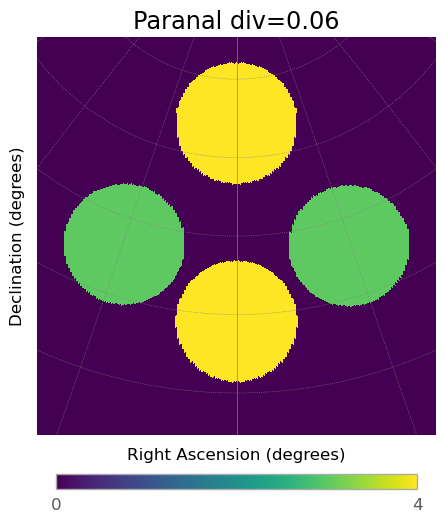

In [84]:
array.divergent_pointing(div=0.06, az=0, alt=70)
array.multiplicity_plot(number_of_telescopes_subarray_1)
array_3.divergent_pointing(div=0.06, az=0, alt=70)
array_3.multiplicity_plot(number_of_telescopes_subarray_3)

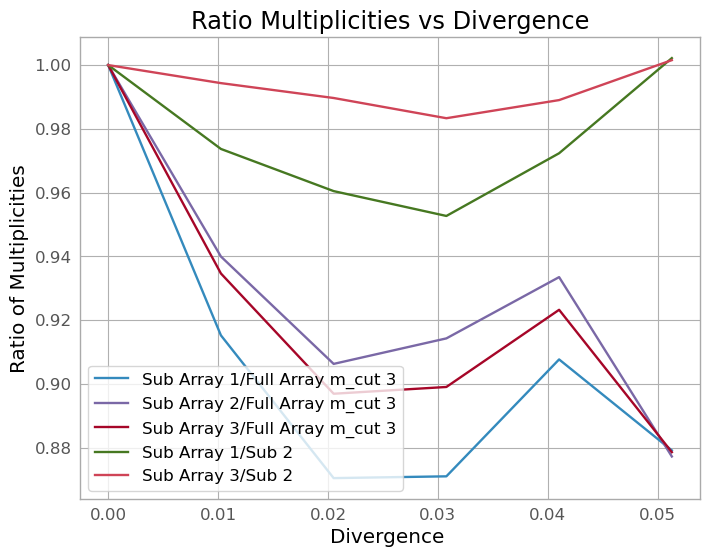

In [85]:
plt.plot(div, multiplicity_array/multiplicity_full_array, label='Sub Array 1/Full Array m_cut 3')
plt.plot(div, multiplicity_array_2/multiplicity_full_array, label='Sub Array 2/Full Array m_cut 3')
plt.plot(div, multiplicity_array_3/multiplicity_full_array, label='Sub Array 3/Full Array m_cut 3')
plt.plot(div[:6], multiplicity_array[:6]/multiplicity_array_2[:6], label='Sub Array 1/Sub 2')
plt.plot(div[:6], multiplicity_array_3[:6]/multiplicity_array_2[:6], label='Sub Array 3/Sub 2')
plt.xlabel("Divergence ")  
plt.ylabel("Ratio of Multiplicities")  
plt.title("Ratio Multiplicities vs Divergence")  
plt.legend()

plt.show()

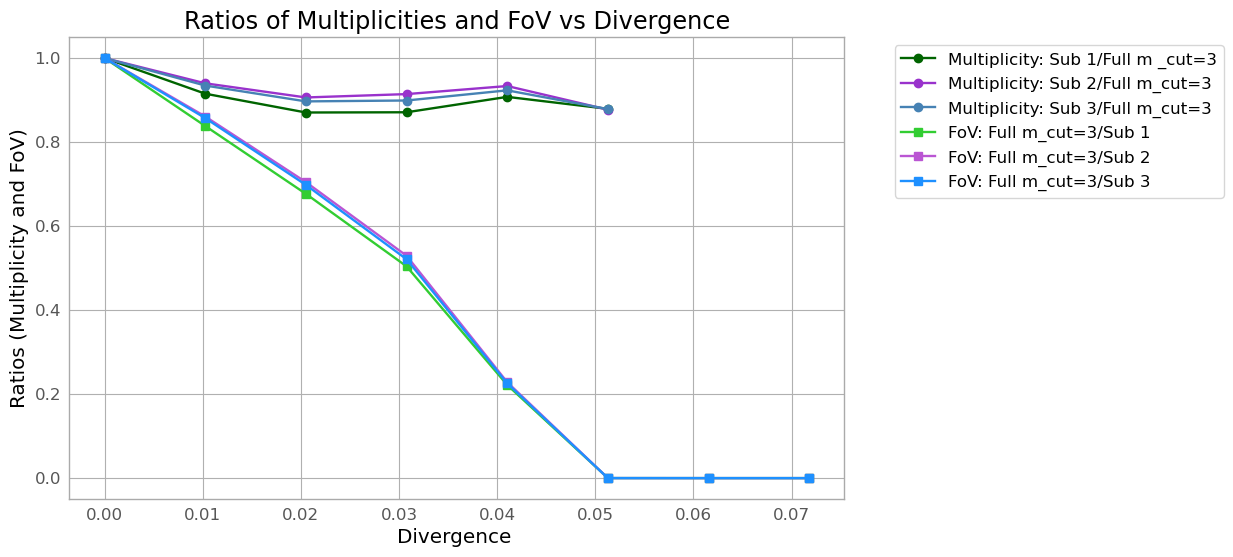

In [86]:
plt.figure(figsize=(10, 6))  # Optional: Adjust figure size

# Scatter plots for Multiplicity ratios m_cut =3
plt.plot(div[:8], multiplicity_array[:8]/multiplicity_full_array[:8], label='Multiplicity: Sub 1/Full m _cut=3', marker='o', color='darkgreen')
plt.plot(div[:8],  multiplicity_array_2[:8]/multiplicity_full_array[:8], label='Multiplicity: Sub 2/Full m_cut=3',marker='o', color='darkorchid')
plt.plot(div[:8],  multiplicity_array_3[:8]/multiplicity_full_array[:8], label='Multiplicity: Sub 3/Full m_cut=3',marker='o', color='steelblue')

# Scatter plots for FoV ratios
plt.plot(div[:8], FoV_full_array[:8]/ FoV_array[:8], label='FoV: Full m_cut=3/Sub 1',marker='s', color='limegreen')
plt.plot(div[:8],FoV_full_array[:8]/ FoV_array_2[:8], label='FoV: Full m_cut=3/Sub 2', marker='s', color='mediumorchid')
plt.plot(div[:8],FoV_full_array[:8]/ FoV_array_3[:8], label='FoV: Full m_cut=3/Sub 3', marker='s', color='dodgerblue')



# Add labels, title, and legend
plt.xlabel("Divergence ")  
plt.ylabel("Ratios (Multiplicity and FoV)")  
plt.title("Ratios of Multiplicities and FoV vs Divergence")  
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))

# Display the plot
plt.show()

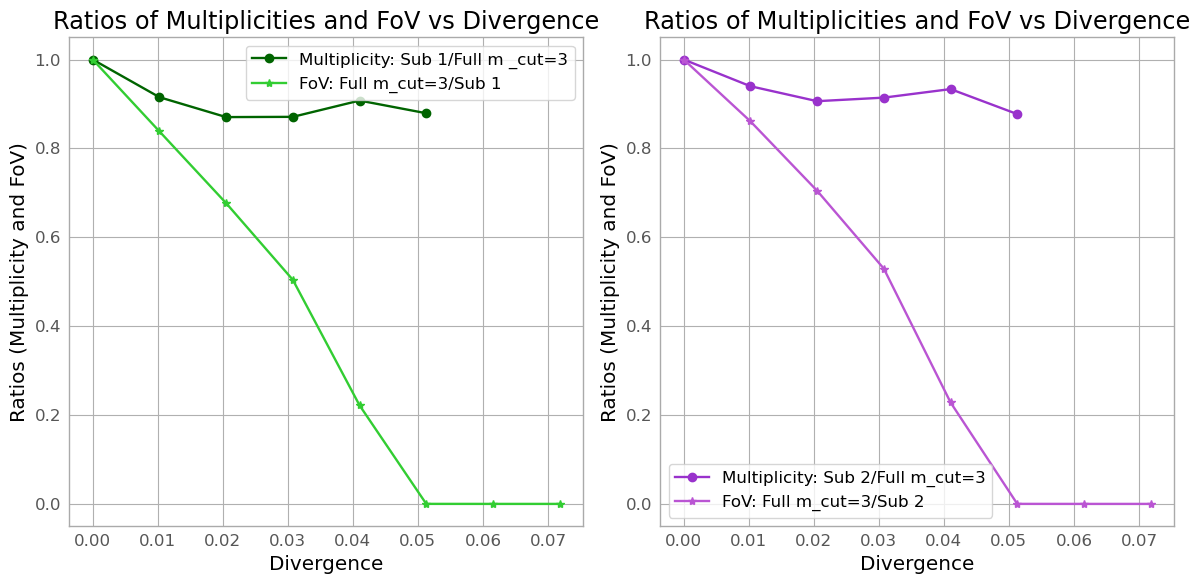

In [87]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6)) 
# Plot Full ArrayFoV_mult_cut_2_array multiplicity_full_array_mult_cut_2
# Scatter plots for Multiplicity ratios m_cut =3
axes[0].plot(div[:8], multiplicity_array[:8]/multiplicity_full_array[:8], label='Multiplicity: Sub 1/Full m _cut=3', marker='o', color='darkgreen')
axes[0].plot(div[:8], FoV_full_array[:8]/ FoV_array[:8], label='FoV: Full m_cut=3/Sub 1',marker='*', color='limegreen')
axes[0].set_title('Ratios of Multiplicities and FoV vs Divergence')
axes[0].set_xlabel('Divergence')
axes[0].set_ylabel('Ratios (Multiplicity and FoV)')
axes[0].legend()

# Plot Full Array 2
axes[1].plot(div[:8], multiplicity_array_2[:8]/multiplicity_full_array[:8], label='Multiplicity: Sub 2/Full m_cut=3',marker='o', color='darkorchid')
axes[1].plot(div[:8], FoV_full_array[:8]/ FoV_array_2[:8], label='FoV: Full m_cut=3/Sub 2', marker='*', color='mediumorchid')
axes[1].set_title('Ratios of Multiplicities and FoV vs Divergence')
axes[1].set_xlabel('Divergence')
axes[1].set_ylabel('Ratios (Multiplicity and FoV)')
axes[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [88]:
 multiplicity_array_2

array([14.        ,  8.8167465 ,  6.20599625,  4.7141095 ,  3.81539525,
        3.50911017,  3.50003526,  3.49985927,  3.50042259,  3.50007042,
        3.4997887 ,  3.4995777 ,  3.49954261,  3.50010563,  3.49992958,
        3.50017599,  3.50049337,  3.50028161,  3.50024657,  3.5       ,
        3.50038713,  3.50017607,  3.50095131,  3.49996479,  3.50017597,
        3.50045765,  3.50028177,  3.50017607,  3.50014069,  3.49985914,
        3.50014086,  3.49950732,  3.50042265,  3.49968281,  3.49968321,
        3.50028185,  3.50003518,  3.50035221,  3.50024639,  3.49992955])

In [89]:
multiplicity_full_array

array([14.        ,  9.37976509,  6.84754476,  5.15594193,  4.08711739,
        4.        ,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan])

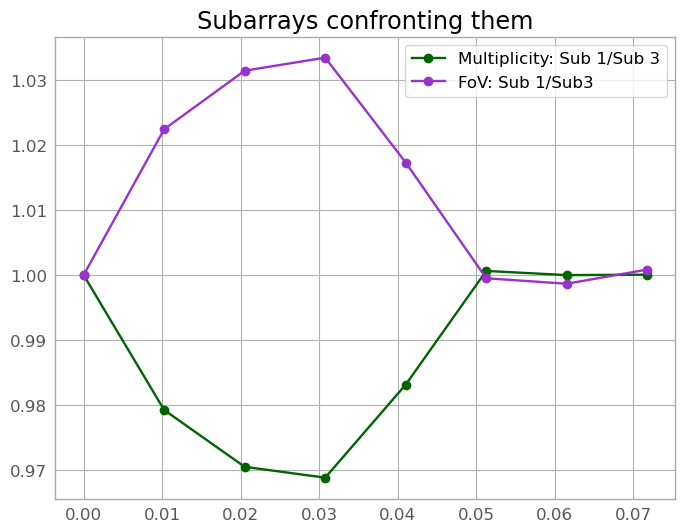

In [90]:
plt.plot(div[:8], multiplicity_array[:8]/multiplicity_array_3[:8], label='Multiplicity: Sub 1/Sub 3', marker='o', color='darkgreen')
#plt.plot(div[:12], multiplicity_array_cut_4[:12]/multiplicity_array_2[:12], label='Multiplicity: Sub 1/Sub 2 cut 4', marker='o')
#plt.plot(div[:8],  FoV_array_cut_4[:8]/FoV_array_2[:8], label='FoV: Sub 1/Sub2 cut 4',marker='o', color='darkorchid')
plt.plot(div[:8],  FoV_array[:8]/FoV_array_3[:8], label='FoV: Sub 1/Sub3',marker='o', color='darkorchid')
plt.title("Subarrays confronting them")
plt.legend()
plt.show()


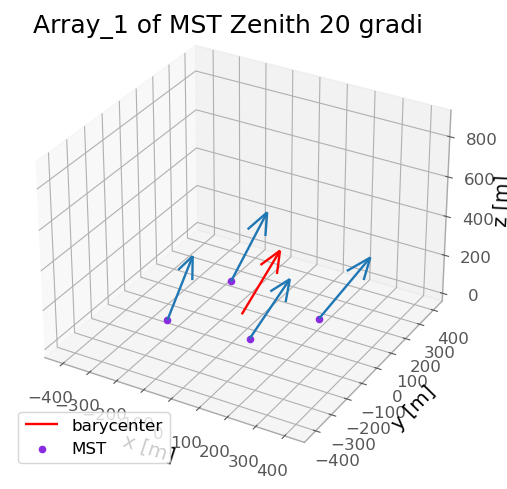

In [131]:
#array_alt_1.display("xyz")
#fig = plt.figure()
ax = array.display("xyz")

colors = [
    'lightseagreen' if np.isclose(fov, 14.5356) else
    'blueviolet' if np.isclose(fov, 46.707) else 
    'green' if np.isclose(fov, 62.462) else
    'red'  # Default color if none of the conditions match
    for fov in array.table["fov"]
]
fov_labels = {
    'lightseagreen': 'LST',
    'blueviolet': 'MST',
    'green': 'SST'
}

#array_3.display("xyz",color=c,label=label)

for i in range(len(array.table)):
    # Color each telescope point according to the FoV
    ax.scatter(array.table['x'][i], array.table['y'][i], array.table['z'][i], 
               color=colors[i], label=fov_labels[colors[i]])

# Display a legend with unique labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

ax.legend(by_label.values(), by_label.keys(), loc='lower left')
ax.text2D(0.05, 0.95, "Array of MST Zenith 20 gradi", 
          transform=ax.transAxes, fontsize=18)
plt.gcf().savefig("./array_ZENITH_20.png", dpi=300)


plt.show()
##SST IN GREEN 
#VIOLET ARE THE MST 
#LIGHT GREEN IS THE LST 

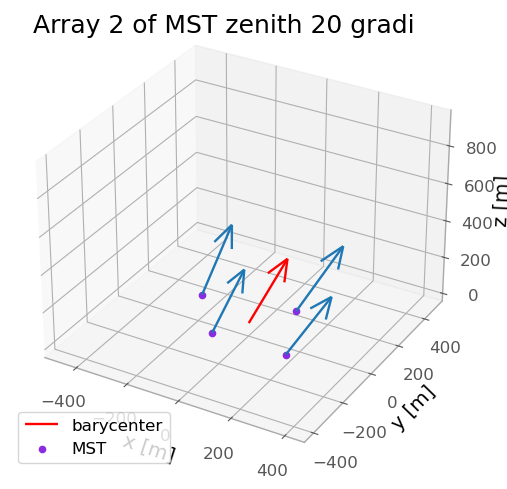

In [134]:
#array_alt_1.display("xyz")
#fig = plt.figure()
ax = array_2.display("xyz")

colors = [
    'lightseagreen' if np.isclose(fov, 14.5356) else
    'blueviolet' if np.isclose(fov, 46.707) else 
    'green' if np.isclose(fov, 62.462) else
    'red'  # Default color if none of the conditions match
    for fov in array_2_alt_1.table["fov"]
]
fov_labels = {
    'lightseagreen': 'LST',
    'blueviolet': 'MST',
    'green': 'SST'
}

for i in range(len(array_2.table)):
    # Color each telescope point according to the FoV
    ax.scatter(array_2.table['x'][i], array_2.table['y'][i], array_2.table['z'][i], 
               color=colors[i], label=fov_labels[colors[i]])

# Display a legend with unique labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

ax.legend(by_label.values(), by_label.keys(), loc='lower left')
ax.text2D(0.05, 0.95, "Array 2 of MST zenith 20 gradi", 
          transform=ax.transAxes, fontsize=18)


# Display a legend with unique labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())


plt.show()

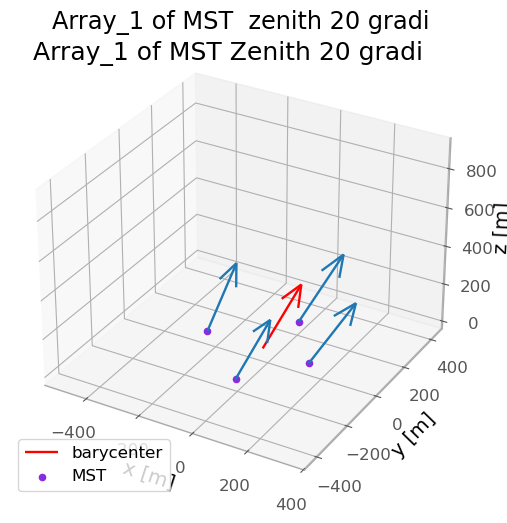

In [135]:
#array_alt_1.display("xyz")
#fig = plt.figure()
ax = array_3.display("xyz")

colors = [
    'lightseagreen' if np.isclose(fov, 14.5356) else
    'blueviolet' if np.isclose(fov, 46.707) else 
    'green' if np.isclose(fov, 62.462) else
    'red'  # Default color if none of the conditions match
    for fov in array.table["fov"]
]
fov_labels = {
    'lightseagreen': 'LST',
    'blueviolet': 'MST',
    'green': 'SST'
}


#array_3.display("xyz",color=c,label=label)

for i in range(len(array_3.table)):
    # Color each telescope point according to the FoV
    ax.scatter(array_3.table['x'][i], array_3.table['y'][i], array_3.table['z'][i], 
               color=colors[i], label=fov_labels[colors[i]])

# Display a legend with unique labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

ax.legend(by_label.values(), by_label.keys(), loc='lower left')
ax.text2D(0.05, 0.95, "Array_1 of MST Zenith 20 gradi", 
          transform=ax.transAxes, fontsize=18)
plt.gcf().savefig("./array_ZENITH_20.png", dpi=300)


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.title("Array_1 of MST  zenith 20 gradi")

plt.show()
##SST IN GREEN 